In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time
import warnings
from collections import deque
import psutil
import os

In [2]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json' 

TARGET_MODULATIONS = ['OOK','4ASK','8ASK','BPSK', 'QPSK', '8PSK', '16QAM',
                     '64QAM']
#TARGET_MODULATIONS = ['OOK','4ASK','BPSK', 'QPSK', '8PSK','16QAM','GMSK']
BATCH_SIZE = 1024 # adjust to my laptop 
#LEARNING_RATE = 0.003 
NUM_EPOCHS = 300 
NUM_WORKERS = 0 #Temporary check it  

INPUT_CHANNELS = 2 
SEQUENCE_LENGTH = 1024 
NUM_CLASSES = len(TARGET_MODULATIONS) # adjust this to 

patience = 25
# TRAIN_RATIO = 0.7 
# VALID_RATIO = 0.2 
# TEST_RATIO = 0.1 

nf_train = int(BATCH_SIZE * 0.7)
nf_valid = int(BATCH_SIZE * 0.2)
nf_test  = BATCH_SIZE - nf_train - nf_valid

print("📋 Training Parameters:")
print(f"  Batch size: {BATCH_SIZE}")
#print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

📋 Training Parameters:
  Batch size: 1024
  Epochs: 300


In [4]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.8, # training 70 %
                  valid_proportion=0.2, # validation 20 %
                  test_proportion=0.0, # testing 10 % 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []                                   

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [5]:
class RadioMLIQDataset(Dataset):
    """Dataset class for RadioML18 data formatted for CNNIQModel dual-branch architecture.
    
    Loads RadioML18 HDF5 data and returns separate I and Q tensors in 2D format
    suitable for CNNIQModel's separate branch processing.
    """
    
    def __init__(self, mode: str, use_fft: bool = False, seed: int = 48):
        """Initialize RadioMLIQDataset.
        
        Args:
            mode: Dataset split mode ('train', 'valid', or 'test').
            use_fft: Whether to apply FFT transformation to signals.
            seed: Random seed for dataset splitting.
            
        Raises:
            FileNotFoundError: If HDF5 or JSON files cannot be found.
            ValueError: If mode is not valid or data dimensions are incompatible.
        """
        super(RadioMLIQDataset, self).__init__()
        
        # Configuration (you'll need to define these constants)
        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft
        self.mode = mode
        
        # Validate mode
        if mode not in ['train', 'valid', 'test']:
            raise ValueError(f"Mode must be 'train', 'valid', or 'test', got '{mode}'")
        
        # Load data files
        try:
            self.hdf5_file = h5py.File(self.file_path, 'r')
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Error loading data files: {e}")
        except Exception as e:
            print(f"Error loading file: {e}")
            raise e
        
        # Load raw data
        self.X = self.hdf5_file['X']
        self.Y = np.argmax(self.hdf5_file['Y'], axis=1)
        self.Z = self.hdf5_file['Z'][:, 0]
        
       
        num_mods = len(self.target_modulations)   
        num_snrs = 26         
        
        train_proportion = (num_mods * num_snrs * nf_train) / self.X.shape[0]
        valid_proportion = (num_mods * num_snrs * nf_valid) / self.X.shape[0]
        test_proportion  = (num_mods * num_snrs * nf_test ) / self.X.shape[0]
        
        self.target_snrs = np.unique(self.Z)
        
        # Split dataset
        self.X_data, self.Y_data, self.Z_data = dataset_split(
            data=self.X,
            modulations_classes=self.modulation_classes,
            modulations=self.Y,
            snrs=self.Z,
            mode=mode,
            train_proportion=train_proportion,
            valid_proportion=valid_proportion,
            test_proportion=test_proportion,
            target_modulations=self.target_modulations,
            target_snrs=self.target_snrs,
            seed=seed
        )
        
        # Apply I/Q swap correction for AMC compatibility
        # print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
        self.X_data = self.X_data[:, :, [0, 1]]
        # print(f"✅ I/Q channels corrected for real-world compatibility")
        
        # Validate signal length for 2D reshaping
        signal_length = self.X_data.shape[1]
        if signal_length != 1024:
            raise ValueError(f"Expected signal length 1024 for 32x32 reshape, got {signal_length}")

        import math
        
        L = signal_length
        H = int(math.floor(math.sqrt(L)))
        while L % H != 0:
            H -= 1
        W = L // H
        
        self.H, self.W = H, W
        print(f"🔧 Signals will be reshaped to ({H}, {W}) for sequence length {L}")
        print(f"✅ Aspect ratio: {W/H:.2f}, Total elements preserved: {H*W} = {L}")
        
        if self.use_fft:
            print("Dataset configured to use FFT as input")
        
        # Store dataset statistics
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
        print(f"RadioMLIQDataset {mode}: {self.num_data} samples, "
              f"{self.num_lbl} classes, {self.num_snr} SNR levels")
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset.
        
        Returns:
            Number of samples.
        """
        return self.X_data.shape[0]
    

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= self.num_data:
            raise IndexError(f"Index {idx} out of range for dataset of size {self.num_data}")

        # Raw sample
        x_raw = self.X_data[idx]       # shape: (L, 2)
        y     = int(self.Y_data[idx])  # scalar label
        z     = float(self.Z_data[idx])

        # To tensor & transpose to (2, L)
        x = torch.from_numpy(x_raw).float().transpose(0, 1)

        # Optional FFT preprocessing
        if self.use_fft:
            complex_sig = torch.complex(x[0], x[1])
            fft_res     = torch.fft.fft(complex_sig)
            x_real = torch.real(fft_res)
            x_imag = torch.imag(fft_res)
            x = torch.stack([x_real, x_imag], dim=0)

        # Separate I/Q
        i_signal = x[0]  # (L,)
        q_signal = x[1]

        # Convert to amplitude & phase
        amplitude = torch.sqrt(i_signal**2 + q_signal**2)
        phase     = torch.atan2(q_signal, i_signal)

        # Dynamic reshape to 2D
        i_2d = amplitude.view(1, self.H, self.W)
        q_2d = phase.view(1, self.H, self.W)

        return i_2d, q_2d, y, z

    def get_signal_stats(self):
        """Compute basic stats over a sample of signals."""
        sample_indices = np.random.choice(self.num_data, min(1000, self.num_data), replace=False)
        i_vals, q_vals = [], []
        for idx in sample_indices:
            i2d, q2d, _, _ = self[idx]
            i_vals.append(i2d.flatten())
            q_vals.append(q2d.flatten())
        i_all = torch.cat(i_vals)
        q_all = torch.cat(q_vals)
        return {
            'i_mean': i_all.mean().item(),
            'i_std':  i_all.std().item(),
            'q_mean': q_all.mean().item(),
            'q_std':  q_all.std().item(),
            'shape':  (1, self.H, self.W),
            'num_samples': self.num_data
        }

    def close(self):
        if hasattr(self, 'hdf5_file'):
            self.hdf5_file.close()

    def __del__(self):
        self.close()

In [6]:
try:
    from CNN_IQ import create_CNNIQModel

    # Match the real signature: (n_labels, dropout_rate)
    model_CNNIQ = create_CNNIQModel(n_labels=NUM_CLASSES, dropout_rate=0.2).to(device)
    print("✅ Successfully built CNNIQModel:", model_CNNIQ)

except Exception as e:
    print(f"⚠️ Could not build CNNIQModel: {e}")

✅ Successfully built CNNIQModel: CNNIQModel(
  (i_branch): CNNIQBranch(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (leaky_relu): LeakyReLU(negative_slope=0.1, inplace=True)
    (dropout): Dropout2d(p=0.15000000000000002, inplace=False)
    (global_avg_pool): A

C:\Users\N208\AppData\Local\Temp\ipykernel_10572\3523442702.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset valid: 14144 samples, 8 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 49504
Train dataset size: 49504 (80%)
Validation dataset size: 14144 (20%)

Starting training...


Training:   0%|                      | 0/49 [00:00<?, ?it/s]C:\Users\N208\AppData\Local\Temp\ipykernel_10572\3523442702.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training: 100%|█████████████| 49/49 [00:07<00:00,  7.08it/s]
                                                            
Validation:   0%|                    | 0/14 [00:00<?, ?it/s]
                                                            C:\Users\N208\.conda\envs\amc_env\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/i

Epoch 1/300: Train Loss: 2.5625 | Train Acc: 31.49% | Valid Loss: 1.8898 | Valid Acc: 34.40%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.09it/s]
                                                            
Epochs:   1%|▏                                  | 2/300 [00:16<40:21,  8.13s/it]

Epoch 2/300: Train Loss: 1.7421 | Train Acc: 41.27% | Valid Loss: 1.5466 | Valid Acc: 47.94%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.11it/s]
                                                            
Epochs:   1%|▎                                  | 3/300 [00:24<39:19,  7.95s/it]

Epoch 3/300: Train Loss: 1.6414 | Train Acc: 45.02% | Valid Loss: 1.5440 | Valid Acc: 48.83%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.15it/s]
                                                            
Epochs:   1%|▍                                  | 4/300 [00:31<38:43,  7.85s/it]

Epoch 4/300: Train Loss: 1.5934 | Train Acc: 47.45% | Valid Loss: 1.4988 | Valid Acc: 52.43%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.17it/s]
                                                            
Epochs:   2%|▌                                  | 5/300 [00:39<38:17,  7.79s/it]

Epoch 5/300: Train Loss: 1.5685 | Train Acc: 48.69% | Valid Loss: 1.5170 | Valid Acc: 49.57%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.22it/s]
                                                            
Epochs:   2%|▋                                  | 6/300 [00:47<37:59,  7.76s/it]

Epoch 6/300: Train Loss: 1.5534 | Train Acc: 50.03% | Valid Loss: 1.4847 | Valid Acc: 52.20%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.01it/s]
                                                            
Epochs:   2%|▊                                  | 7/300 [00:54<37:53,  7.76s/it]

Epoch 7/300: Train Loss: 1.5321 | Train Acc: 51.60% | Valid Loss: 1.4557 | Valid Acc: 55.25%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  6.94it/s]
                                                            
Epochs:   3%|▉                                  | 8/300 [01:02<37:51,  7.78s/it]

Epoch 8/300: Train Loss: 1.5191 | Train Acc: 52.90% | Valid Loss: 1.4546 | Valid Acc: 55.39%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.09it/s]
                                                            
Epochs:   3%|█                                  | 9/300 [01:10<37:42,  7.78s/it]

Epoch 9/300: Train Loss: 1.5076 | Train Acc: 53.81% | Valid Loss: 1.4340 | Valid Acc: 56.76%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.09it/s]
                                                            
Epochs:   3%|█▏                                | 10/300 [01:18<37:32,  7.77s/it]

Epoch 10/300: Train Loss: 1.4962 | Train Acc: 54.46% | Valid Loss: 1.4254 | Valid Acc: 57.38%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.16it/s]
                                                            
Epochs:   4%|█▏                                | 11/300 [01:25<37:16,  7.74s/it]

Epoch 11/300: Train Loss: 1.4862 | Train Acc: 55.08% | Valid Loss: 1.4203 | Valid Acc: 57.47%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.16it/s]
                                                            
Epochs:   4%|█▎                                | 12/300 [01:33<37:07,  7.74s/it]

Epoch 12/300: Train Loss: 1.4804 | Train Acc: 55.28% | Valid Loss: 1.4087 | Valid Acc: 58.60%



Training:  96%|████████████▍| 47/49 [00:06<00:00,  7.20it/s]
                                                            
Epochs:   4%|█▍                                | 13/300 [01:41<36:56,  7.72s/it]

Epoch 13/300: Train Loss: 1.4732 | Train Acc: 55.67% | Valid Loss: 1.4165 | Valid Acc: 57.65%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.21it/s]
                                                            
Epochs:   5%|█▌                                | 14/300 [01:49<36:46,  7.71s/it]

Epoch 14/300: Train Loss: 1.4656 | Train Acc: 56.13% | Valid Loss: 1.4203 | Valid Acc: 57.14%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.11it/s]
                                                            
Epochs:   5%|█▋                                | 15/300 [01:56<36:39,  7.72s/it]

Epoch 15/300: Train Loss: 1.4593 | Train Acc: 56.52% | Valid Loss: 1.4013 | Valid Acc: 58.68%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.06it/s]
                                                            
Epochs:   5%|█▊                                | 16/300 [02:04<36:32,  7.72s/it]

Epoch 16/300: Train Loss: 1.4536 | Train Acc: 57.03% | Valid Loss: 1.3934 | Valid Acc: 59.76%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.21it/s]
                                                            
Epochs:   6%|█▉                                | 17/300 [02:12<36:17,  7.69s/it]

Epoch 17/300: Train Loss: 1.4530 | Train Acc: 56.57% | Valid Loss: 1.4002 | Valid Acc: 58.84%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.14it/s]
                                                            
Epochs:   6%|██                                | 18/300 [02:19<36:13,  7.71s/it]

Epoch 18/300: Train Loss: 1.4437 | Train Acc: 57.63% | Valid Loss: 1.3861 | Valid Acc: 60.27%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.20it/s]
                                                            
Epochs:   6%|██▏                               | 19/300 [02:27<36:01,  7.69s/it]

Epoch 19/300: Train Loss: 1.4394 | Train Acc: 57.59% | Valid Loss: 1.3844 | Valid Acc: 59.66%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.25it/s]
                                                            
Epochs:   7%|██▎                               | 20/300 [02:35<35:50,  7.68s/it]

Epoch 20/300: Train Loss: 1.4375 | Train Acc: 57.91% | Valid Loss: 1.4005 | Valid Acc: 58.75%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.16it/s]
                                                            
Epochs:   7%|██▍                               | 21/300 [02:42<35:39,  7.67s/it]

Epoch 21/300: Train Loss: 1.4343 | Train Acc: 58.20% | Valid Loss: 1.4963 | Valid Acc: 50.86%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.11it/s]
                                                            
Epochs:   7%|██▍                               | 22/300 [02:50<35:34,  7.68s/it]

Epoch 22/300: Train Loss: 1.4299 | Train Acc: 58.37% | Valid Loss: 1.3883 | Valid Acc: 59.95%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.17it/s]
                                                            
Epochs:   8%|██▌                               | 23/300 [02:58<35:34,  7.71s/it]

Epoch 23/300: Train Loss: 1.4271 | Train Acc: 58.37% | Valid Loss: 1.3930 | Valid Acc: 58.35%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.18it/s]
                                                            
Epochs:   8%|██▋                               | 24/300 [03:06<35:23,  7.69s/it]

Epoch 24/300: Train Loss: 1.4231 | Train Acc: 58.74% | Valid Loss: 1.3907 | Valid Acc: 59.23%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.16it/s]
                                                            
Epochs:   8%|██▊                               | 25/300 [03:13<35:17,  7.70s/it]

Epoch 25/300: Train Loss: 1.4215 | Train Acc: 58.88% | Valid Loss: 1.4464 | Valid Acc: 54.91%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.17it/s]
                                                            
Epochs:   9%|██▉                               | 26/300 [03:21<35:05,  7.68s/it]

Epoch 26/300: Train Loss: 1.4157 | Train Acc: 59.31% | Valid Loss: 1.3939 | Valid Acc: 58.64%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.18it/s]
                                                            
Epochs:   9%|███                               | 27/300 [03:29<34:57,  7.68s/it]

Epoch 27/300: Train Loss: 1.4135 | Train Acc: 59.06% | Valid Loss: 1.3703 | Valid Acc: 60.84%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.17it/s]
                                                            
Epochs:   9%|███▏                              | 28/300 [03:36<34:50,  7.69s/it]

Epoch 28/300: Train Loss: 1.4127 | Train Acc: 59.22% | Valid Loss: 1.3836 | Valid Acc: 59.84%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.24it/s]
                                                            
Epochs:  10%|███▎                              | 29/300 [03:44<34:41,  7.68s/it]

Epoch 29/300: Train Loss: 1.4092 | Train Acc: 59.33% | Valid Loss: 1.3633 | Valid Acc: 61.50%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.02it/s]
                                                            
Epochs:  10%|███▍                              | 30/300 [03:52<34:37,  7.69s/it]

Epoch 30/300: Train Loss: 1.4061 | Train Acc: 59.55% | Valid Loss: 1.3676 | Valid Acc: 60.67%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.04it/s]
                                                            
Epochs:  10%|███▌                              | 31/300 [03:59<34:34,  7.71s/it]

Epoch 31/300: Train Loss: 1.4056 | Train Acc: 59.72% | Valid Loss: 1.3879 | Valid Acc: 59.38%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.11it/s]
                                                            
Epochs:  11%|███▋                              | 32/300 [04:07<34:29,  7.72s/it]

Epoch 32/300: Train Loss: 1.4029 | Train Acc: 59.80% | Valid Loss: 1.3721 | Valid Acc: 61.06%



Training:  96%|████████████▍| 47/49 [00:06<00:00,  6.94it/s]
                                                            
Epochs:  11%|███▋                              | 33/300 [04:15<34:34,  7.77s/it]

Epoch 33/300: Train Loss: 1.4002 | Train Acc: 60.11% | Valid Loss: 1.4528 | Valid Acc: 54.76%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.02it/s]
                                                            
Epochs:  11%|███▊                              | 34/300 [04:23<34:24,  7.76s/it]

Epoch 34/300: Train Loss: 1.3980 | Train Acc: 60.13% | Valid Loss: 1.3593 | Valid Acc: 61.50%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.23it/s]
                                                            
Epochs:  12%|███▉                              | 35/300 [04:30<34:03,  7.71s/it]

Epoch 35/300: Train Loss: 1.3964 | Train Acc: 60.44% | Valid Loss: 1.3782 | Valid Acc: 60.05%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.16it/s]
                                                            
Epochs:  12%|████                              | 36/300 [04:38<33:51,  7.70s/it]

Epoch 36/300: Train Loss: 1.3955 | Train Acc: 60.31% | Valid Loss: 1.3747 | Valid Acc: 59.81%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.16it/s]
                                                            
Epochs:  12%|████▏                             | 37/300 [04:46<33:41,  7.69s/it]

Epoch 37/300: Train Loss: 1.3924 | Train Acc: 60.75% | Valid Loss: 1.3529 | Valid Acc: 61.75%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.10it/s]
                                                            
Epochs:  13%|████▎                             | 38/300 [04:53<33:35,  7.69s/it]

Epoch 38/300: Train Loss: 1.3894 | Train Acc: 60.78% | Valid Loss: 1.3613 | Valid Acc: 61.32%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.18it/s]
                                                            
Epochs:  13%|████▍                             | 39/300 [05:01<33:31,  7.71s/it]

Epoch 39/300: Train Loss: 1.3893 | Train Acc: 60.85% | Valid Loss: 1.4322 | Valid Acc: 57.08%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.04it/s]
                                                            
Epochs:  13%|████▌                             | 40/300 [05:09<33:28,  7.72s/it]

Epoch 40/300: Train Loss: 1.3860 | Train Acc: 61.07% | Valid Loss: 1.3487 | Valid Acc: 62.43%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.15it/s]
                                                            
Epochs:  14%|████▋                             | 41/300 [05:17<33:25,  7.74s/it]

Epoch 41/300: Train Loss: 1.3784 | Train Acc: 61.76% | Valid Loss: 1.3433 | Valid Acc: 62.79%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.20it/s]
                                                            
Epochs:  14%|████▊                             | 42/300 [05:24<33:10,  7.71s/it]

Epoch 42/300: Train Loss: 1.3788 | Train Acc: 61.89% | Valid Loss: 1.3477 | Valid Acc: 62.56%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.16it/s]
                                                            
Epochs:  14%|████▊                             | 43/300 [05:32<33:01,  7.71s/it]

Epoch 43/300: Train Loss: 1.3749 | Train Acc: 61.84% | Valid Loss: 1.3368 | Valid Acc: 63.48%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.14it/s]
                                                            
Epochs:  15%|████▉                             | 44/300 [05:40<32:54,  7.71s/it]

Epoch 44/300: Train Loss: 1.3725 | Train Acc: 62.37% | Valid Loss: 1.4239 | Valid Acc: 56.60%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.19it/s]
                                                            
Epochs:  15%|█████                             | 45/300 [05:47<32:46,  7.71s/it]

Epoch 45/300: Train Loss: 1.3705 | Train Acc: 62.17% | Valid Loss: 1.3768 | Valid Acc: 59.67%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.04it/s]
                                                            
Epochs:  15%|█████▏                            | 46/300 [05:55<32:39,  7.72s/it]

Epoch 46/300: Train Loss: 1.3672 | Train Acc: 62.74% | Valid Loss: 1.3282 | Valid Acc: 64.05%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.00it/s]
                                                            
Epochs:  16%|█████▎                            | 47/300 [06:03<32:33,  7.72s/it]

Epoch 47/300: Train Loss: 1.3646 | Train Acc: 62.76% | Valid Loss: 1.4533 | Valid Acc: 55.87%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.17it/s]
                                                            
Epochs:  16%|█████▍                            | 48/300 [06:11<32:21,  7.70s/it]

Epoch 48/300: Train Loss: 1.3622 | Train Acc: 63.28% | Valid Loss: 1.4601 | Valid Acc: 55.68%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.19it/s]
                                                            
Epochs:  16%|█████▌                            | 49/300 [06:18<32:16,  7.71s/it]

Epoch 49/300: Train Loss: 1.3624 | Train Acc: 63.00% | Valid Loss: 1.3593 | Valid Acc: 61.68%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.23it/s]
                                                            
Epochs:  17%|█████▋                            | 50/300 [06:26<31:59,  7.68s/it]

Epoch 50/300: Train Loss: 1.3541 | Train Acc: 63.68% | Valid Loss: 1.3278 | Valid Acc: 63.96%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.20it/s]
                                                            
Epochs:  17%|█████▊                            | 51/300 [06:34<31:50,  7.67s/it]

Epoch 51/300: Train Loss: 1.3505 | Train Acc: 63.86% | Valid Loss: 1.3409 | Valid Acc: 63.38%



Training:  96%|████████████▍| 47/49 [00:06<00:00,  7.21it/s]
                                                            
Epochs:  17%|█████▉                            | 52/300 [06:41<31:42,  7.67s/it]

Epoch 52/300: Train Loss: 1.3516 | Train Acc: 63.74% | Valid Loss: 1.3392 | Valid Acc: 62.78%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.18it/s]
                                                            
Epochs:  18%|██████                            | 53/300 [06:49<31:33,  7.67s/it]

Epoch 53/300: Train Loss: 1.3454 | Train Acc: 64.32% | Valid Loss: 1.3292 | Valid Acc: 63.74%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.17it/s]
                                                            
Epochs:  18%|██████                            | 54/300 [06:57<31:31,  7.69s/it]

Epoch 54/300: Train Loss: 1.3488 | Train Acc: 64.01% | Valid Loss: 1.3206 | Valid Acc: 64.15%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  6.99it/s]
                                                            
Epochs:  18%|██████▏                           | 55/300 [07:04<31:27,  7.71s/it]

Epoch 55/300: Train Loss: 1.3398 | Train Acc: 64.71% | Valid Loss: 1.3806 | Valid Acc: 59.89%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.07it/s]
                                                            
Epochs:  19%|██████▎                           | 56/300 [07:12<31:20,  7.71s/it]

Epoch 56/300: Train Loss: 1.3363 | Train Acc: 64.95% | Valid Loss: 1.3306 | Valid Acc: 63.29%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.10it/s]
                                                            
Epochs:  19%|██████▍                           | 57/300 [07:20<31:15,  7.72s/it]

Epoch 57/300: Train Loss: 1.3361 | Train Acc: 64.76% | Valid Loss: 1.4618 | Valid Acc: 55.78%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.03it/s]
                                                            
Epochs:  19%|██████▌                           | 58/300 [07:28<31:18,  7.76s/it]

Epoch 58/300: Train Loss: 1.3336 | Train Acc: 64.82% | Valid Loss: 1.3352 | Valid Acc: 62.91%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  6.94it/s]
                                                            
Epochs:  20%|██████▋                           | 59/300 [07:36<31:15,  7.78s/it]

Epoch 59/300: Train Loss: 1.3278 | Train Acc: 65.26% | Valid Loss: 1.3070 | Valid Acc: 65.27%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.04it/s]
                                                            
Epochs:  20%|██████▊                           | 60/300 [07:43<31:13,  7.81s/it]

Epoch 60/300: Train Loss: 1.3325 | Train Acc: 65.11% | Valid Loss: 1.3279 | Valid Acc: 63.34%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.18it/s]
                                                            
Epochs:  20%|██████▉                           | 61/300 [07:51<30:56,  7.77s/it]

Epoch 61/300: Train Loss: 1.3280 | Train Acc: 65.41% | Valid Loss: 1.3104 | Valid Acc: 65.13%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.06it/s]
                                                            
Epochs:  21%|███████                           | 62/300 [07:59<30:45,  7.75s/it]

Epoch 62/300: Train Loss: 1.3214 | Train Acc: 65.94% | Valid Loss: 1.3126 | Valid Acc: 64.64%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.20it/s]
                                                            
Epochs:  21%|███████▏                          | 63/300 [08:06<30:29,  7.72s/it]

Epoch 63/300: Train Loss: 1.3236 | Train Acc: 65.81% | Valid Loss: 1.3107 | Valid Acc: 64.96%



Training:  96%|████████████▍| 47/49 [00:06<00:00,  7.17it/s]
                                                            
Epochs:  21%|███████▎                          | 64/300 [08:14<30:27,  7.74s/it]

Epoch 64/300: Train Loss: 1.3194 | Train Acc: 65.96% | Valid Loss: 1.4005 | Valid Acc: 59.91%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.19it/s]
                                                            
Epochs:  22%|███████▎                          | 65/300 [08:22<30:13,  7.72s/it]

Epoch 65/300: Train Loss: 1.3165 | Train Acc: 66.12% | Valid Loss: 1.3074 | Valid Acc: 65.07%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.19it/s]
                                                            
Epochs:  22%|███████▍                          | 66/300 [08:30<30:03,  7.71s/it]

Epoch 66/300: Train Loss: 1.3182 | Train Acc: 65.99% | Valid Loss: 1.3142 | Valid Acc: 64.67%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.24it/s]
                                                            
Epochs:  22%|███████▌                          | 67/300 [08:37<29:52,  7.69s/it]

Epoch 67/300: Train Loss: 1.3141 | Train Acc: 66.13% | Valid Loss: 1.3225 | Valid Acc: 64.18%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.13it/s]
                                                            
Epochs:  23%|███████▋                          | 68/300 [08:45<29:44,  7.69s/it]

Epoch 68/300: Train Loss: 1.3101 | Train Acc: 66.70% | Valid Loss: 1.3003 | Valid Acc: 66.03%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.08it/s]
                                                            
Epochs:  23%|███████▊                          | 69/300 [08:53<29:38,  7.70s/it]

Epoch 69/300: Train Loss: 1.3113 | Train Acc: 66.49% | Valid Loss: 1.3056 | Valid Acc: 65.41%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.19it/s]
                                                            
Epochs:  23%|███████▉                          | 70/300 [09:00<29:27,  7.68s/it]

Epoch 70/300: Train Loss: 1.3103 | Train Acc: 66.66% | Valid Loss: 1.3112 | Valid Acc: 64.82%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.09it/s]
                                                            
Epochs:  24%|████████                          | 71/300 [09:08<29:22,  7.70s/it]

Epoch 71/300: Train Loss: 1.3101 | Train Acc: 66.44% | Valid Loss: 1.3232 | Valid Acc: 64.33%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.12it/s]
                                                            
Epochs:  24%|████████▏                         | 72/300 [09:16<29:16,  7.70s/it]

Epoch 72/300: Train Loss: 1.3038 | Train Acc: 66.94% | Valid Loss: 1.2919 | Valid Acc: 66.35%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.13it/s]
                                                            
Epochs:  24%|████████▎                         | 73/300 [09:23<29:07,  7.70s/it]

Epoch 73/300: Train Loss: 1.3052 | Train Acc: 66.76% | Valid Loss: 1.3094 | Valid Acc: 65.35%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.23it/s]
                                                            
Epochs:  25%|████████▍                         | 74/300 [09:31<28:58,  7.69s/it]

Epoch 74/300: Train Loss: 1.3025 | Train Acc: 66.81% | Valid Loss: 1.3576 | Valid Acc: 61.92%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.08it/s]
                                                            
Epochs:  25%|████████▌                         | 75/300 [09:39<28:51,  7.70s/it]

Epoch 75/300: Train Loss: 1.3022 | Train Acc: 66.91% | Valid Loss: 1.2921 | Valid Acc: 66.35%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.20it/s]
                                                            
Epochs:  25%|████████▌                         | 76/300 [09:47<28:46,  7.71s/it]

Epoch 76/300: Train Loss: 1.3001 | Train Acc: 67.09% | Valid Loss: 1.2964 | Valid Acc: 66.03%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.14it/s]
                                                            
Epochs:  26%|████████▋                         | 77/300 [09:54<28:37,  7.70s/it]

Epoch 77/300: Train Loss: 1.2981 | Train Acc: 67.15% | Valid Loss: 1.3721 | Valid Acc: 60.92%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.11it/s]
                                                            
Epochs:  26%|████████▊                         | 78/300 [10:02<28:31,  7.71s/it]

Epoch 78/300: Train Loss: 1.2959 | Train Acc: 67.51% | Valid Loss: 1.3976 | Valid Acc: 60.36%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.14it/s]
                                                            
Epochs:  26%|████████▉                         | 79/300 [10:10<28:25,  7.72s/it]

Epoch 79/300: Train Loss: 1.2906 | Train Acc: 67.77% | Valid Loss: 1.3018 | Valid Acc: 65.70%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.15it/s]
                                                            
Epochs:  27%|█████████                         | 80/300 [10:17<28:21,  7.74s/it]

Epoch 80/300: Train Loss: 1.2912 | Train Acc: 67.79% | Valid Loss: 1.2886 | Valid Acc: 66.52%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.04it/s]
                                                            
Epochs:  27%|█████████▏                        | 81/300 [10:25<28:12,  7.73s/it]

Epoch 81/300: Train Loss: 1.2903 | Train Acc: 67.82% | Valid Loss: 1.3065 | Valid Acc: 65.38%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.10it/s]
                                                            
Epochs:  27%|█████████▎                        | 82/300 [10:33<28:01,  7.71s/it]

Epoch 82/300: Train Loss: 1.2887 | Train Acc: 67.94% | Valid Loss: 1.2957 | Valid Acc: 66.11%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.14it/s]
                                                            
Epochs:  28%|█████████▍                        | 83/300 [10:41<27:51,  7.70s/it]

Epoch 83/300: Train Loss: 1.2867 | Train Acc: 67.98% | Valid Loss: 1.2921 | Valid Acc: 66.27%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.02it/s]
                                                            
Epochs:  28%|█████████▌                        | 84/300 [10:48<27:46,  7.72s/it]

Epoch 84/300: Train Loss: 1.2856 | Train Acc: 68.22% | Valid Loss: 1.3325 | Valid Acc: 63.85%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.18it/s]
                                                            
Epochs:  28%|█████████▋                        | 85/300 [10:56<27:39,  7.72s/it]

Epoch 85/300: Train Loss: 1.2857 | Train Acc: 68.12% | Valid Loss: 1.3202 | Valid Acc: 64.68%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.16it/s]
                                                            
Epochs:  29%|█████████▋                        | 86/300 [11:04<27:28,  7.70s/it]

Epoch 86/300: Train Loss: 1.2850 | Train Acc: 68.16% | Valid Loss: 1.3510 | Valid Acc: 63.10%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.06it/s]
                                                            
Epochs:  29%|█████████▊                        | 87/300 [11:11<27:22,  7.71s/it]

Epoch 87/300: Train Loss: 1.2824 | Train Acc: 68.26% | Valid Loss: 1.3034 | Valid Acc: 65.58%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.15it/s]
                                                            
Epochs:  29%|█████████▉                        | 88/300 [11:19<27:14,  7.71s/it]

Epoch 88/300: Train Loss: 1.2787 | Train Acc: 68.69% | Valid Loss: 1.2985 | Valid Acc: 66.19%



Training:  94%|████████████▏| 46/49 [00:06<00:00,  7.12it/s]
                                                            
Epochs:  30%|██████████                        | 89/300 [11:27<27:17,  7.76s/it]

Epoch 89/300: Train Loss: 1.2762 | Train Acc: 68.91% | Valid Loss: 1.2840 | Valid Acc: 66.69%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.20it/s]
                                                            
Epochs:  30%|██████████▏                       | 90/300 [11:35<27:01,  7.72s/it]

Epoch 90/300: Train Loss: 1.2772 | Train Acc: 68.63% | Valid Loss: 1.2964 | Valid Acc: 66.00%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.04it/s]
                                                            
Epochs:  30%|██████████▎                       | 91/300 [11:42<26:52,  7.71s/it]

Epoch 91/300: Train Loss: 1.2757 | Train Acc: 68.88% | Valid Loss: 1.2844 | Valid Acc: 66.69%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.19it/s]
                                                            
Epochs:  31%|██████████▍                       | 92/300 [11:50<26:39,  7.69s/it]

Epoch 92/300: Train Loss: 1.2730 | Train Acc: 69.06% | Valid Loss: 1.2968 | Valid Acc: 66.18%



Training:  96%|████████████▍| 47/49 [00:06<00:00,  7.05it/s]
                                                            
Epochs:  31%|██████████▌                       | 93/300 [11:58<26:40,  7.73s/it]

Epoch 93/300: Train Loss: 1.2709 | Train Acc: 69.15% | Valid Loss: 1.3651 | Valid Acc: 62.10%



Training:  96%|████████████▍| 47/49 [00:06<00:00,  7.11it/s]
                                                            
Epochs:  31%|██████████▋                       | 94/300 [12:06<26:36,  7.75s/it]

Epoch 94/300: Train Loss: 1.2710 | Train Acc: 69.41% | Valid Loss: 1.3127 | Valid Acc: 65.37%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.13it/s]
                                                            
Epochs:  32%|██████████▊                       | 95/300 [12:13<26:28,  7.75s/it]

Epoch 95/300: Train Loss: 1.2677 | Train Acc: 69.53% | Valid Loss: 1.2957 | Valid Acc: 66.01%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.19it/s]
                                                            
Epochs:  32%|██████████▉                       | 96/300 [12:21<26:18,  7.74s/it]

Epoch 96/300: Train Loss: 1.2700 | Train Acc: 69.31% | Valid Loss: 1.2924 | Valid Acc: 66.51%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.15it/s]
                                                            
Epochs:  32%|██████████▉                       | 97/300 [12:29<26:06,  7.72s/it]

Epoch 97/300: Train Loss: 1.2640 | Train Acc: 69.53% | Valid Loss: 1.3342 | Valid Acc: 64.34%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.14it/s]
                                                            
Epochs:  33%|███████████                       | 98/300 [12:36<25:56,  7.70s/it]

Epoch 98/300: Train Loss: 1.2637 | Train Acc: 69.73% | Valid Loss: 1.3738 | Valid Acc: 62.37%



Training:  98%|████████████▋| 48/49 [00:06<00:00,  7.16it/s]
                                                            
Epochs:  33%|███████████                       | 98/300 [12:44<26:16,  7.80s/it]


Early stopping at epoch 99

Training complete.
Best validation accuracy: 66.69%


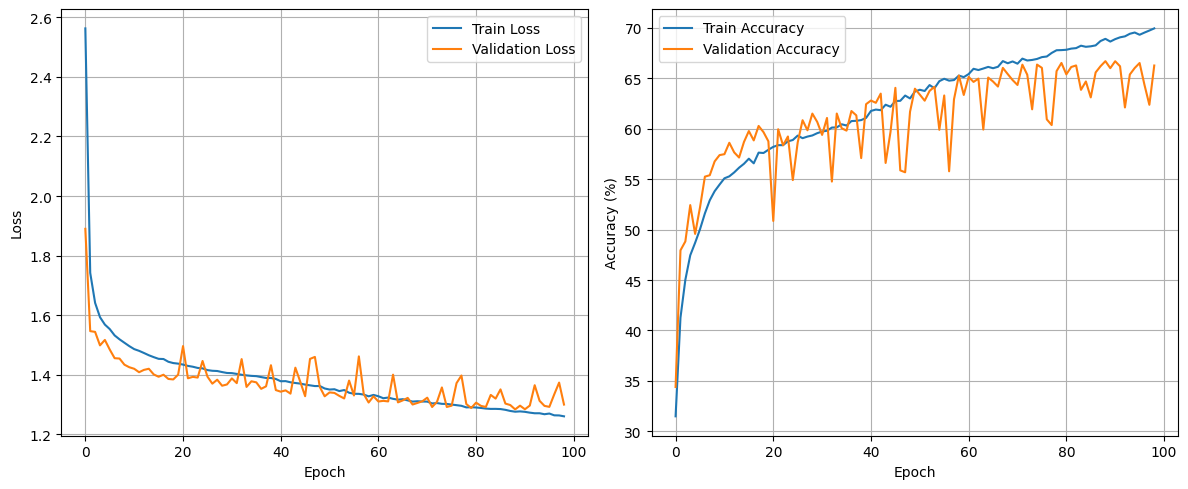

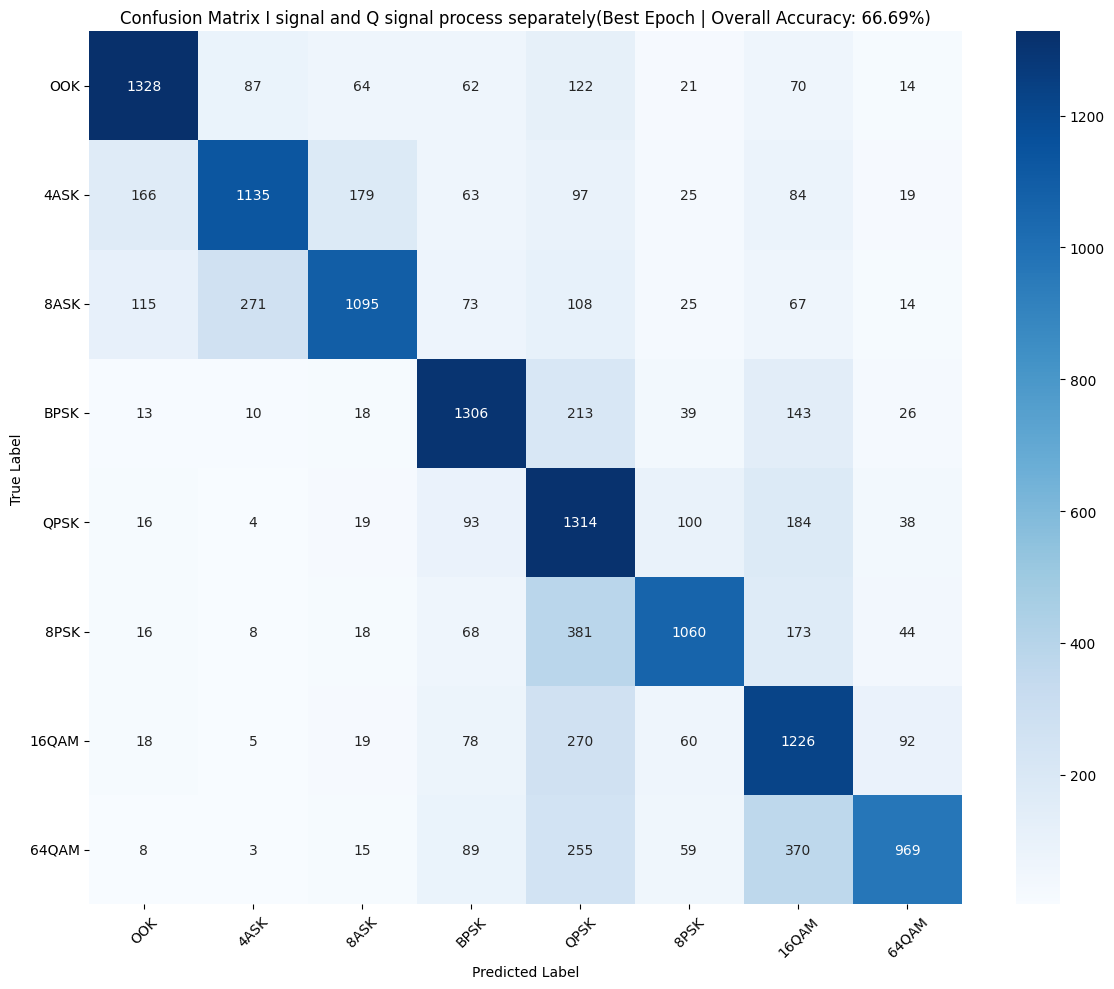

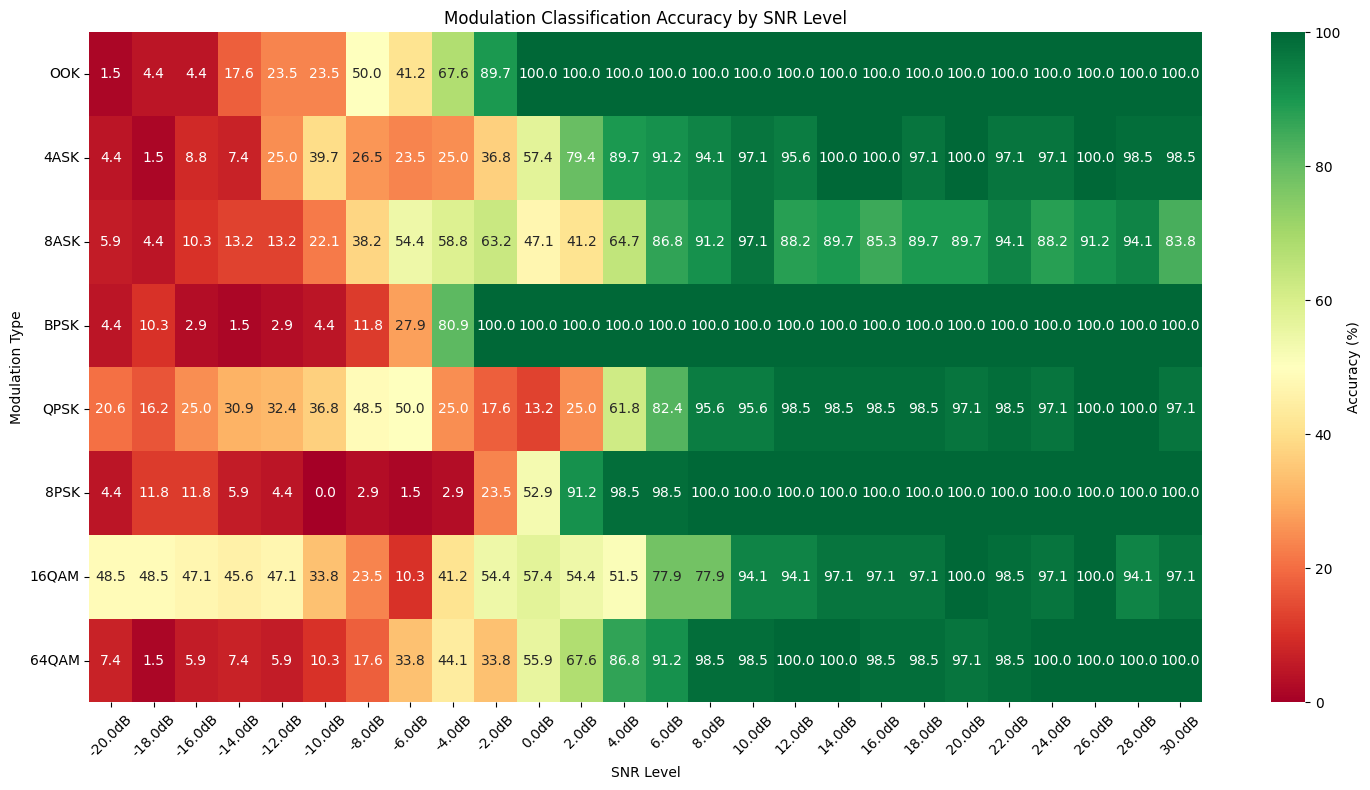

In [7]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    model_CNNIQ.parameters(), 
    lr=0.0015,  # Higher initial LR
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

# Step scheduler
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[50, 100, 150], 
    gamma=0.5
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model_IQ.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal process separately(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('Modulation Classification Accuracy by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_heatm.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNIQ, valid_loader, device, TARGET_MODULATIONS)

C:\Users\N208\AppData\Local\Temp\ipykernel_10572\1106508062.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset valid: 14144 samples, 8 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 49504
Train dataset size: 49504 (80%)
Validation dataset size: 14144 (20%)

Starting training...


Training:   0%|                      | 0/49 [00:00<?, ?it/s]C:\Users\N208\AppData\Local\Temp\ipykernel_10572\1106508062.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.80it/s]
                                                            
Epochs:   0%|                                   | 1/300 [00:11<58:57, 11.83s/it]

Epoch 1/300: Train Loss: 1.2002 | Train Acc: 71.67% | Valid Loss: 1.3989 | Valid Acc: 60.92%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  5.01it/s]
                                                            
Epochs:   1%|▏                                  | 2/300 [00:23<57:24, 11.56s/it]

Epoch 2/300: Train Loss: 1.1843 | Train Acc: 72.58% | Valid Loss: 1.3509 | Valid Acc: 63.59%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  4.98it/s]
                                                            
Epochs:   1%|▎                                  | 3/300 [00:34<57:17, 11.57s/it]

Epoch 3/300: Train Loss: 1.1799 | Train Acc: 72.82% | Valid Loss: 1.2878 | Valid Acc: 65.57%



Training:  98%|████████████▋| 48/49 [00:09<00:00,  4.97it/s]
                                                            
Epochs:   1%|▍                                  | 4/300 [00:46<57:07, 11.58s/it]

Epoch 4/300: Train Loss: 1.1791 | Train Acc: 72.93% | Valid Loss: 1.3398 | Valid Acc: 63.19%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  4.89it/s]
                                                            
Epochs:   2%|▌                                  | 5/300 [00:58<57:09, 11.63s/it]

Epoch 5/300: Train Loss: 1.1795 | Train Acc: 72.77% | Valid Loss: 1.3903 | Valid Acc: 63.32%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.97it/s]
                                                            
Epochs:   2%|▋                                  | 6/300 [01:09<57:07, 11.66s/it]

Epoch 6/300: Train Loss: 1.1736 | Train Acc: 72.95% | Valid Loss: 1.3090 | Valid Acc: 64.90%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.81it/s]
                                                            
Epochs:   2%|▊                                  | 7/300 [01:21<57:05, 11.69s/it]

Epoch 7/300: Train Loss: 1.1714 | Train Acc: 73.25% | Valid Loss: 1.2864 | Valid Acc: 66.11%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.98it/s]
                                                            
Epochs:   3%|▉                                  | 8/300 [01:33<56:32, 11.62s/it]

Epoch 8/300: Train Loss: 1.1702 | Train Acc: 73.37% | Valid Loss: 1.2946 | Valid Acc: 65.50%



Training: 100%|█████████████| 49/49 [00:09<00:00,  5.11it/s]
                                                            
Epochs:   3%|█                                  | 9/300 [01:44<56:19, 11.61s/it]

Epoch 9/300: Train Loss: 1.1690 | Train Acc: 73.36% | Valid Loss: 1.3712 | Valid Acc: 62.21%



Training:  98%|████████████▋| 48/49 [00:09<00:00,  4.86it/s]
                                                            
Epochs:   3%|█▏                                | 10/300 [01:56<56:03, 11.60s/it]

Epoch 10/300: Train Loss: 1.1676 | Train Acc: 73.67% | Valid Loss: 1.3181 | Valid Acc: 65.16%



Training:  98%|████████████▋| 48/49 [00:09<00:00,  5.00it/s]
                                                            
Epochs:   4%|█▏                                | 11/300 [02:07<55:48, 11.59s/it]

Epoch 11/300: Train Loss: 1.1641 | Train Acc: 73.99% | Valid Loss: 1.3650 | Valid Acc: 63.42%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  5.01it/s]
                                                            
Epochs:   4%|█▎                                | 12/300 [02:19<55:22, 11.54s/it]

Epoch 12/300: Train Loss: 1.1409 | Train Acc: 75.36% | Valid Loss: 1.2844 | Valid Acc: 66.87%



Training:  98%|████████████▋| 48/49 [00:09<00:00,  4.93it/s]
                                                            
Epochs:   4%|█▍                                | 13/300 [02:30<55:31, 11.61s/it]

Epoch 13/300: Train Loss: 1.1300 | Train Acc: 76.24% | Valid Loss: 1.3251 | Valid Acc: 65.70%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.91it/s]
                                                            
Epochs:   5%|█▌                                | 14/300 [02:42<55:22, 11.62s/it]

Epoch 14/300: Train Loss: 1.1302 | Train Acc: 76.46% | Valid Loss: 1.3144 | Valid Acc: 66.49%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.92it/s]
                                                            
Epochs:   5%|█▋                                | 15/300 [02:54<55:20, 11.65s/it]

Epoch 15/300: Train Loss: 1.1226 | Train Acc: 76.63% | Valid Loss: 1.3102 | Valid Acc: 66.46%



Training:  90%|███████████▋ | 44/49 [00:09<00:01,  4.80it/s]
                                                            
Epochs:   5%|█▊                                | 16/300 [03:06<55:15, 11.67s/it]

Epoch 16/300: Train Loss: 1.1246 | Train Acc: 76.72% | Valid Loss: 1.3581 | Valid Acc: 65.31%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.83it/s]
                                                            
Epochs:   6%|█▉                                | 17/300 [03:17<55:08, 11.69s/it]

Epoch 17/300: Train Loss: 1.1076 | Train Acc: 77.60% | Valid Loss: 1.3061 | Valid Acc: 66.88%



Training:  90%|███████████▋ | 44/49 [00:08<00:01,  4.93it/s]
                                                            
Epochs:   6%|██                                | 18/300 [03:29<54:46, 11.65s/it]

Epoch 18/300: Train Loss: 1.0984 | Train Acc: 78.40% | Valid Loss: 1.3134 | Valid Acc: 66.76%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  4.87it/s]
                                                            
Epochs:   6%|██▏                               | 19/300 [03:41<54:35, 11.66s/it]

Epoch 19/300: Train Loss: 1.0972 | Train Acc: 78.40% | Valid Loss: 1.3225 | Valid Acc: 66.50%



Training: 100%|█████████████| 49/49 [00:09<00:00,  5.10it/s]
                                                            
Epochs:   7%|██▎                               | 20/300 [03:52<54:27, 11.67s/it]

Epoch 20/300: Train Loss: 1.0946 | Train Acc: 78.56% | Valid Loss: 1.3225 | Valid Acc: 66.64%



Training:  92%|███████████▉ | 45/49 [00:08<00:00,  5.02it/s]
                                                            
Epochs:   7%|██▍                               | 21/300 [04:04<53:58, 11.61s/it]

Epoch 21/300: Train Loss: 1.0920 | Train Acc: 78.82% | Valid Loss: 1.3308 | Valid Acc: 66.28%



Training: 100%|█████████████| 49/49 [00:09<00:00,  5.19it/s]
                                                            
Epochs:   7%|██▍                               | 22/300 [04:15<53:46, 11.61s/it]

Epoch 22/300: Train Loss: 1.0818 | Train Acc: 79.48% | Valid Loss: 1.3313 | Valid Acc: 66.56%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.79it/s]
                                                            
Epochs:   8%|██▌                               | 23/300 [04:27<53:44, 11.64s/it]

Epoch 23/300: Train Loss: 1.0794 | Train Acc: 79.71% | Valid Loss: 1.3331 | Valid Acc: 66.75%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  4.83it/s]
                                                            
Epochs:   8%|██▋                               | 24/300 [04:39<53:42, 11.68s/it]

Epoch 24/300: Train Loss: 1.0758 | Train Acc: 79.83% | Valid Loss: 1.3268 | Valid Acc: 66.83%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.93it/s]
                                                            
Epochs:   8%|██▊                               | 25/300 [04:50<53:28, 11.67s/it]

Epoch 25/300: Train Loss: 1.0769 | Train Acc: 79.89% | Valid Loss: 1.3374 | Valid Acc: 66.33%



Training:  98%|████████████▋| 48/49 [00:09<00:00,  4.94it/s]
                                                            
Epochs:   9%|██▉                               | 26/300 [05:02<53:18, 11.67s/it]

Epoch 26/300: Train Loss: 1.0717 | Train Acc: 80.34% | Valid Loss: 1.3393 | Valid Acc: 66.42%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.96it/s]
                                                            
Epochs:   9%|██▉                               | 26/300 [05:14<55:12, 12.09s/it]


Early stopping at epoch 27

Training complete.
Best validation accuracy: 66.88%


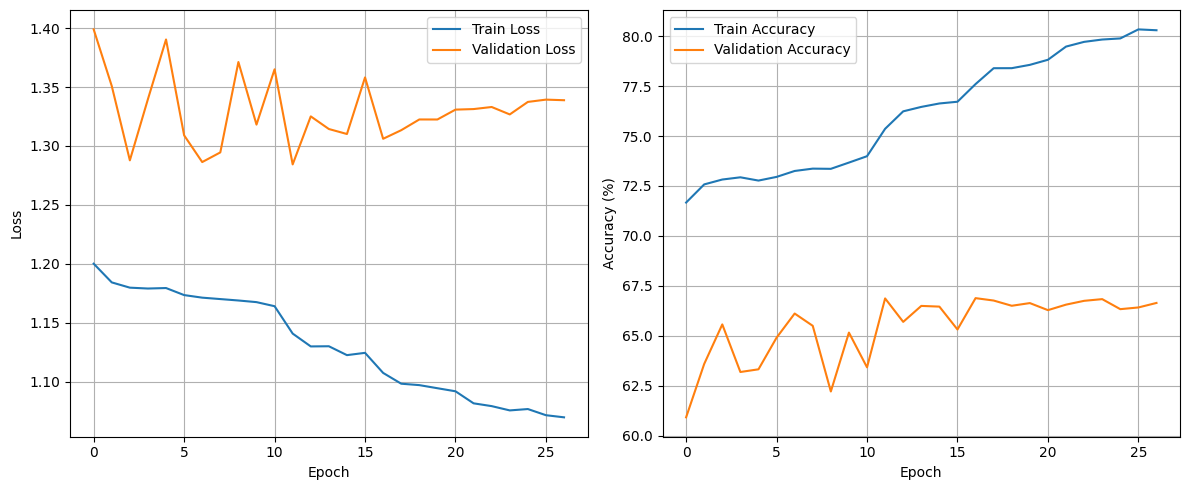

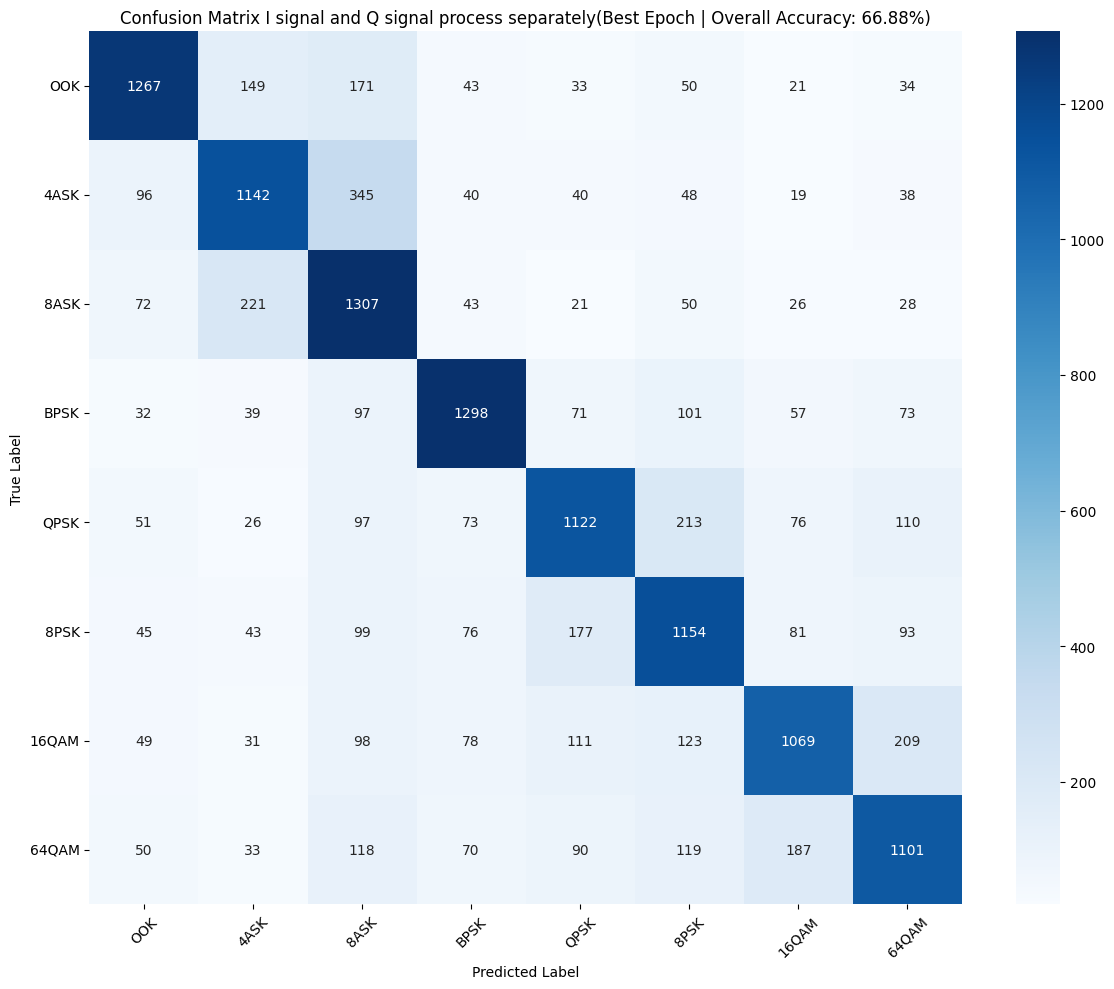

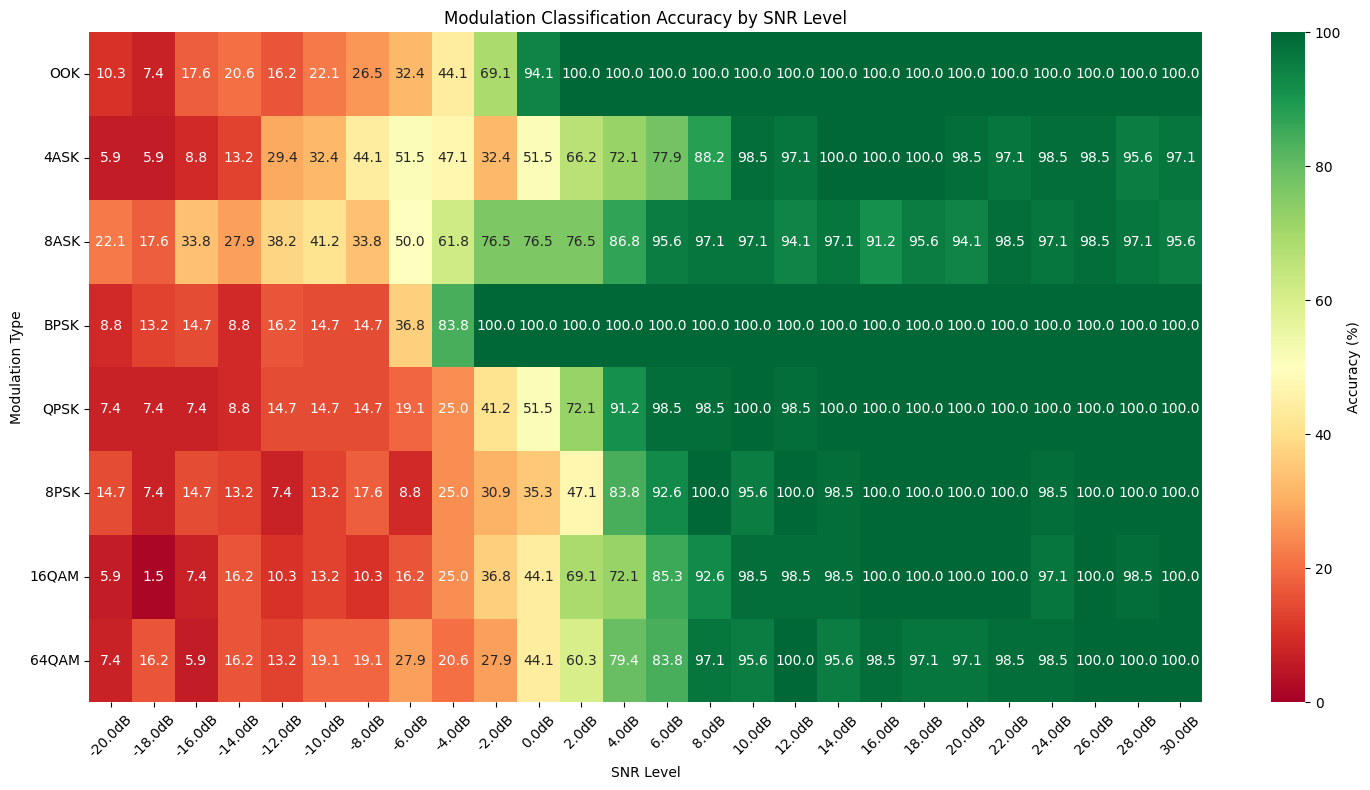

In [12]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.18)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    model_CNNIQ.parameters(), 
    lr=0.0015,  # Higher initial LR
    weight_decay=5e-4,
    betas=(0.9, 0.999)
)

# Step scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)
scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model_IQ2.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal process separately(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix2.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('Modulation Classification Accuracy by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_heatmap2.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNIQ, valid_loader, device, TARGET_MODULATIONS)

C:\Users\N208\AppData\Local\Temp\ipykernel_17232\2153590447.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
Dataset configured to use FFT as input
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
Dataset configured to use FFT as input
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
Dataset configured to use FFT as input
RadioMLIQDataset valid: 14144 samples, 8 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 49504
Train dataset size: 49504 (80%)
Validation dataset size: 14144 (20%)

Starting training...


Training:   0%|                      | 0/49 [00:00<?, ?it/s]C:\Users\N208\AppData\Local\Temp\ipykernel_17232\2153590447.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training:  96%|████████████▍| 47/49 [00:12<00:00,  3.74it/s]
                                                            
Validation:  86%|█████████▍ | 12/14 [00:02<00:00,  5.09it/s]
                                                            C:\Users\N208\.conda\envs\amc_env\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/i

Epoch 1/300: Train Loss: 1.7151 | Train Acc: 31.13% | Valid Loss: 1.6008 | Valid Acc: 34.38%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.67it/s]
                                                            
Epochs:   1%|▏                                | 2/300 [00:31<1:19:24, 15.99s/it]

Epoch 2/300: Train Loss: 1.5773 | Train Acc: 35.36% | Valid Loss: 1.5639 | Valid Acc: 34.74%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.70it/s]
                                                            
Epochs:   1%|▎                                | 3/300 [00:47<1:19:03, 15.97s/it]

Epoch 3/300: Train Loss: 1.5658 | Train Acc: 35.91% | Valid Loss: 1.5506 | Valid Acc: 36.98%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:   1%|▍                                | 4/300 [01:03<1:18:25, 15.90s/it]

Epoch 4/300: Train Loss: 1.5584 | Train Acc: 36.72% | Valid Loss: 1.5505 | Valid Acc: 36.57%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.70it/s]
                                                            
Epochs:   2%|▌                                | 5/300 [01:19<1:18:25, 15.95s/it]

Epoch 5/300: Train Loss: 1.5514 | Train Acc: 36.98% | Valid Loss: 1.5548 | Valid Acc: 36.01%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.66it/s]
                                                            
Epochs:   2%|▋                                | 6/300 [01:35<1:18:02, 15.93s/it]

Epoch 6/300: Train Loss: 1.5460 | Train Acc: 37.33% | Valid Loss: 1.5493 | Valid Acc: 36.93%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.53it/s]
                                                            
Epochs:   2%|▊                                | 7/300 [01:51<1:17:49, 15.94s/it]

Epoch 7/300: Train Loss: 1.5402 | Train Acc: 38.13% | Valid Loss: 1.5571 | Valid Acc: 35.99%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:   3%|▉                                | 8/300 [02:07<1:17:12, 15.86s/it]

Epoch 8/300: Train Loss: 1.5306 | Train Acc: 38.55% | Valid Loss: 1.5559 | Valid Acc: 36.70%



Training:  92%|███████████▉ | 45/49 [00:12<00:01,  3.73it/s]
                                                            
Epochs:   3%|▉                                | 9/300 [02:23<1:16:54, 15.86s/it]

Epoch 9/300: Train Loss: 1.5251 | Train Acc: 39.27% | Valid Loss: 1.5696 | Valid Acc: 36.52%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.71it/s]
                                                            
Epochs:   3%|█                               | 10/300 [02:38<1:16:32, 15.84s/it]

Epoch 10/300: Train Loss: 1.5164 | Train Acc: 39.69% | Valid Loss: 1.5470 | Valid Acc: 37.83%



Training:  92%|███████████▉ | 45/49 [00:12<00:01,  3.71it/s]
                                                            
Epochs:   4%|█▏                              | 11/300 [02:54<1:16:13, 15.83s/it]

Epoch 11/300: Train Loss: 1.5106 | Train Acc: 40.00% | Valid Loss: 1.5534 | Valid Acc: 37.83%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:   4%|█▎                              | 12/300 [03:10<1:15:47, 15.79s/it]

Epoch 12/300: Train Loss: 1.5019 | Train Acc: 40.59% | Valid Loss: 1.5580 | Valid Acc: 37.91%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.66it/s]
                                                            
Epochs:   4%|█▍                              | 13/300 [03:26<1:15:45, 15.84s/it]

Epoch 13/300: Train Loss: 1.4936 | Train Acc: 41.24% | Valid Loss: 1.5485 | Valid Acc: 38.87%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.71it/s]
                                                            
Epochs:   5%|█▍                              | 14/300 [03:42<1:15:24, 15.82s/it]

Epoch 14/300: Train Loss: 1.4797 | Train Acc: 41.77% | Valid Loss: 1.5889 | Valid Acc: 37.32%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.71it/s]
                                                            
Epochs:   5%|█▌                              | 15/300 [03:58<1:15:19, 15.86s/it]

Epoch 15/300: Train Loss: 1.4695 | Train Acc: 42.67% | Valid Loss: 1.5387 | Valid Acc: 38.98%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:   5%|█▋                              | 16/300 [04:13<1:15:00, 15.85s/it]

Epoch 16/300: Train Loss: 1.4549 | Train Acc: 43.27% | Valid Loss: 1.5442 | Valid Acc: 40.02%



Training:  92%|███████████▉ | 45/49 [00:12<00:01,  3.73it/s]
                                                            
Epochs:   6%|█▊                              | 17/300 [04:29<1:14:42, 15.84s/it]

Epoch 17/300: Train Loss: 1.4492 | Train Acc: 43.88% | Valid Loss: 1.5250 | Valid Acc: 40.60%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:   6%|█▉                              | 18/300 [04:45<1:14:28, 15.84s/it]

Epoch 18/300: Train Loss: 1.4401 | Train Acc: 44.09% | Valid Loss: 1.5160 | Valid Acc: 40.79%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.70it/s]
                                                            
Epochs:   6%|██                              | 19/300 [05:01<1:14:11, 15.84s/it]

Epoch 19/300: Train Loss: 1.4315 | Train Acc: 44.57% | Valid Loss: 1.5401 | Valid Acc: 40.57%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.73it/s]
                                                            
Epochs:   7%|██▏                             | 20/300 [05:17<1:13:42, 15.79s/it]

Epoch 20/300: Train Loss: 1.4232 | Train Acc: 45.04% | Valid Loss: 1.6469 | Valid Acc: 35.02%



Training:  96%|████████████▍| 47/49 [00:12<00:00,  3.71it/s]
                                                            
Epochs:   7%|██▏                             | 21/300 [05:33<1:13:41, 15.85s/it]

Epoch 21/300: Train Loss: 1.4194 | Train Acc: 45.44% | Valid Loss: 1.5483 | Valid Acc: 39.82%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.70it/s]
                                                            
Epochs:   7%|██▎                             | 22/300 [05:49<1:13:39, 15.90s/it]

Epoch 22/300: Train Loss: 1.4136 | Train Acc: 45.45% | Valid Loss: 1.5482 | Valid Acc: 40.89%



Training:  92%|███████████▉ | 45/49 [00:12<00:01,  3.71it/s]
                                                            
Epochs:   8%|██▍                             | 23/300 [06:04<1:13:18, 15.88s/it]

Epoch 23/300: Train Loss: 1.4052 | Train Acc: 45.92% | Valid Loss: 1.5921 | Valid Acc: 38.43%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:   8%|██▌                             | 24/300 [06:20<1:12:48, 15.83s/it]

Epoch 24/300: Train Loss: 1.3987 | Train Acc: 46.30% | Valid Loss: 1.5949 | Valid Acc: 40.20%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.68it/s]
                                                            
Epochs:   8%|██▋                             | 25/300 [06:36<1:12:45, 15.88s/it]

Epoch 25/300: Train Loss: 1.3933 | Train Acc: 46.68% | Valid Loss: 1.5462 | Valid Acc: 40.81%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.53it/s]
                                                            
Epochs:   9%|██▊                             | 26/300 [06:52<1:12:31, 15.88s/it]

Epoch 26/300: Train Loss: 1.3873 | Train Acc: 46.91% | Valid Loss: 1.5733 | Valid Acc: 39.84%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:   9%|██▉                             | 27/300 [07:08<1:11:58, 15.82s/it]

Epoch 27/300: Train Loss: 1.3814 | Train Acc: 47.07% | Valid Loss: 1.5481 | Valid Acc: 41.00%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.69it/s]
                                                            
Epochs:   9%|██▉                             | 28/300 [07:24<1:11:48, 15.84s/it]

Epoch 28/300: Train Loss: 1.3763 | Train Acc: 47.60% | Valid Loss: 1.5513 | Valid Acc: 40.73%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.53it/s]
                                                            
Epochs:  10%|███                             | 29/300 [07:40<1:11:42, 15.88s/it]

Epoch 29/300: Train Loss: 1.3714 | Train Acc: 47.81% | Valid Loss: 1.5630 | Valid Acc: 40.94%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:  10%|███▏                            | 30/300 [07:55<1:11:16, 15.84s/it]

Epoch 30/300: Train Loss: 1.3679 | Train Acc: 47.82% | Valid Loss: 1.6021 | Valid Acc: 38.89%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:  10%|███▎                            | 31/300 [08:11<1:11:11, 15.88s/it]

Epoch 31/300: Train Loss: 1.3598 | Train Acc: 48.61% | Valid Loss: 1.5954 | Valid Acc: 38.18%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.63it/s]
                                                            
Epochs:  11%|███▍                            | 32/300 [08:27<1:11:01, 15.90s/it]

Epoch 32/300: Train Loss: 1.3591 | Train Acc: 48.48% | Valid Loss: 1.5994 | Valid Acc: 39.44%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.72it/s]
                                                            
Epochs:  11%|███▌                            | 33/300 [08:43<1:10:26, 15.83s/it]

Epoch 33/300: Train Loss: 1.3446 | Train Acc: 49.17% | Valid Loss: 1.5647 | Valid Acc: 40.91%



Training: 100%|█████████████| 49/49 [00:12<00:00,  3.98it/s]
                                                            
Epochs:  11%|███▋                            | 34/300 [08:59<1:10:13, 15.84s/it]

Epoch 34/300: Train Loss: 1.3424 | Train Acc: 49.29% | Valid Loss: 1.5825 | Valid Acc: 39.89%



Training:  98%|████████████▋| 48/49 [00:13<00:00,  3.66it/s]
                                                            
Epochs:  12%|███▋                            | 35/300 [09:15<1:10:05, 15.87s/it]

Epoch 35/300: Train Loss: 1.3399 | Train Acc: 49.59% | Valid Loss: 1.5984 | Valid Acc: 39.93%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.71it/s]
                                                            
Epochs:  12%|███▊                            | 36/300 [09:31<1:09:42, 15.84s/it]

Epoch 36/300: Train Loss: 1.3354 | Train Acc: 49.89% | Valid Loss: 1.5967 | Valid Acc: 40.62%



Training:  98%|████████████▋| 48/49 [00:12<00:00,  3.71it/s]
                                                            
Epochs:  12%|███▊                            | 36/300 [09:46<1:11:44, 16.30s/it]


Early stopping at epoch 37

Training complete.
Best validation accuracy: 41.00%


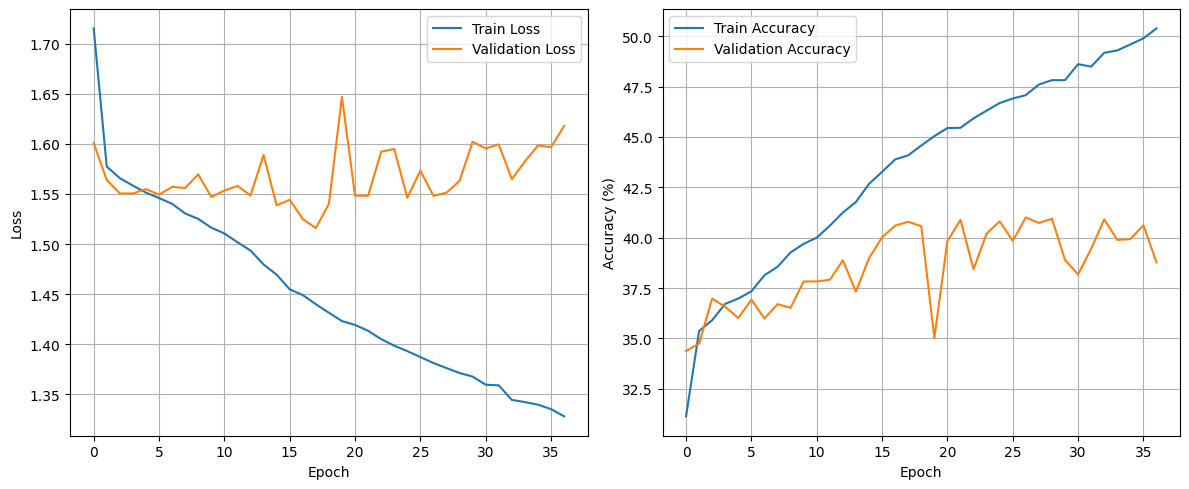

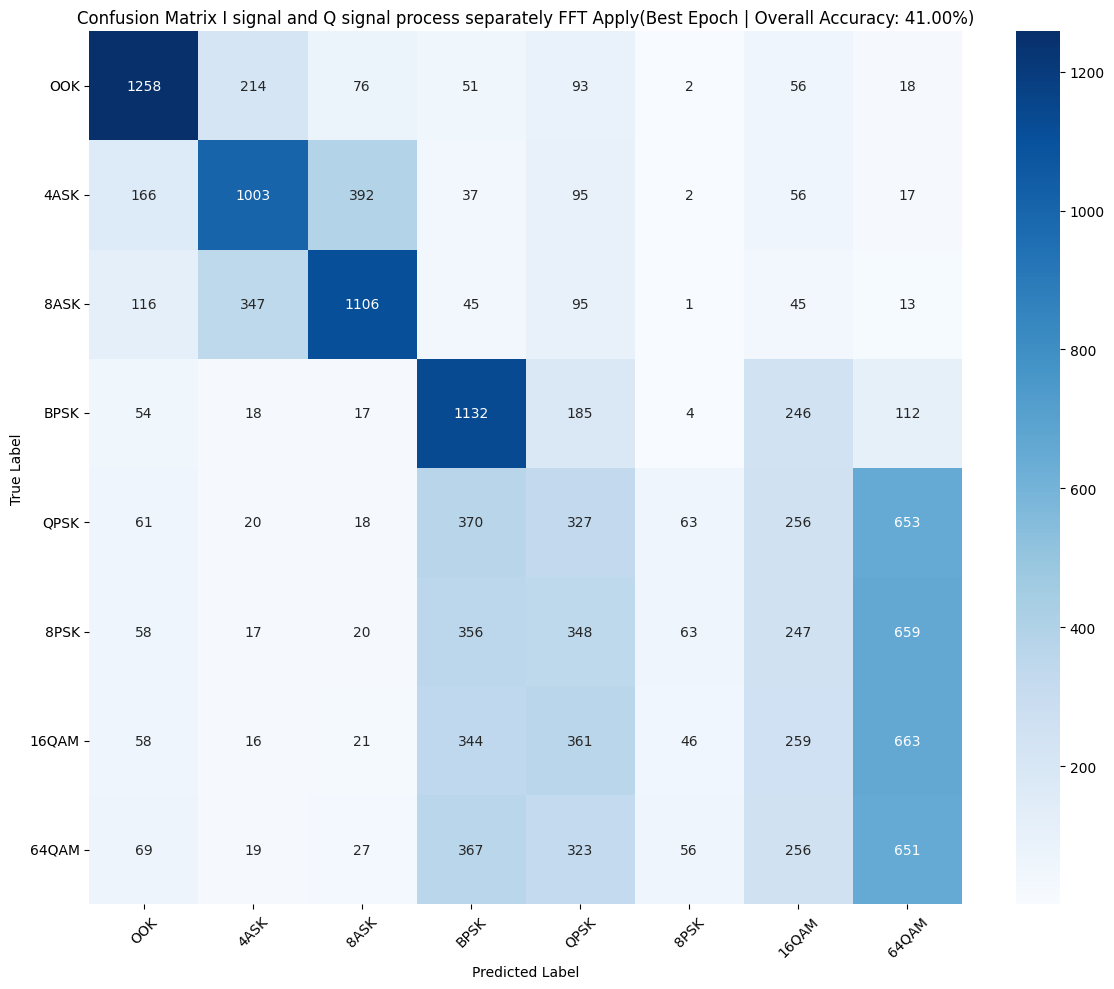

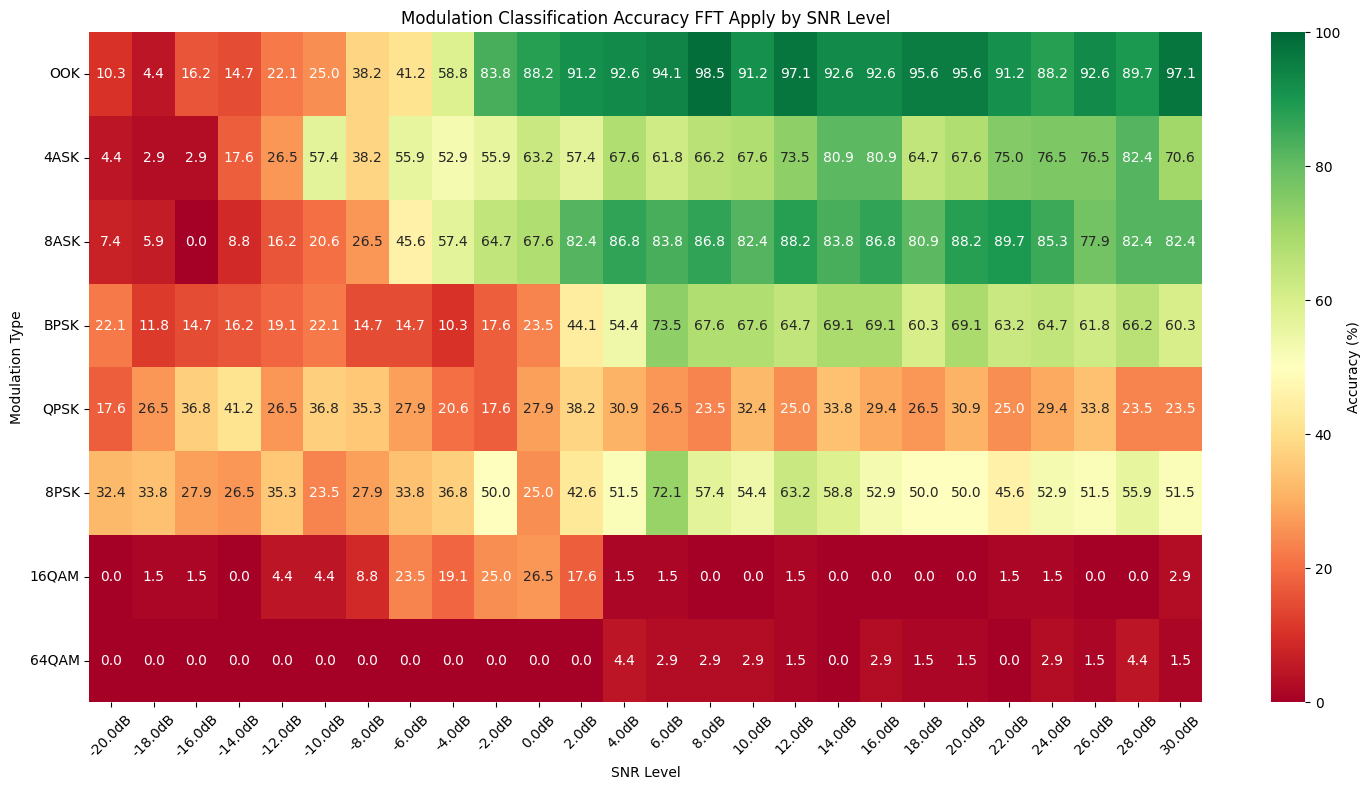

In [24]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    model_CNNIQ.parameters(), 
    lr=0.0015,  # Higher initial LR
    weight_decay=0.005,
    betas=(0.9, 0.999)
)

# Step scheduler
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[75, 125, 175], 
    gamma=0.5
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=True)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=True)
valid_dataset = RadioMLIQDataset('valid', use_fft=True)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0,  # Use some workers for faster loading
    persistent_workers=False
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0,
    persistent_workers=False
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model_IQ.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal process separately FFT Apply(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('best_confusion_matrix.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('Modulation Classification Accuracy FFT Apply by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    #plt.savefig('modulation_snr_accuracy_heatm.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNIQ, valid_loader, device, TARGET_MODULATIONS)

C:\Users\N208\AppData\Local\Temp\ipykernel_17232\2823839515.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset valid: 14144 samples, 8 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 49504
Train dataset size: 49504 (80%)
Validation dataset size: 14144 (20%)

Starting training...


Training:   0%|                      | 0/49 [00:00<?, ?it/s]C:\Users\N208\AppData\Local\Temp\ipykernel_17232\2823839515.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.87it/s]
                                                            
Validation:  57%|██████▊     | 8/14 [00:01<00:00,  7.92it/s]
                                                            C:\Users\N208\.conda\envs\amc_env\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/

Epoch 1/300: Train Loss: 1.2668 | Train Acc: 69.01% | Valid Loss: 1.5644 | Valid Acc: 56.38%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.87it/s]
                                                            
Epochs:   1%|▏                                  | 2/300 [00:23<59:09, 11.91s/it]

Epoch 2/300: Train Loss: 1.2598 | Train Acc: 69.58% | Valid Loss: 1.6307 | Valid Acc: 50.46%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.65it/s]
                                                            
Epochs:   1%|▎                                  | 3/300 [00:35<58:52, 11.89s/it]

Epoch 3/300: Train Loss: 1.2399 | Train Acc: 70.99% | Valid Loss: 1.6170 | Valid Acc: 53.10%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.96it/s]
                                                            
Epochs:   1%|▍                                  | 4/300 [00:47<58:00, 11.76s/it]

Epoch 4/300: Train Loss: 1.2480 | Train Acc: 70.46% | Valid Loss: 1.6875 | Valid Acc: 51.12%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  4.95it/s]
                                                            
Epochs:   2%|▌                                  | 5/300 [00:58<57:37, 11.72s/it]

Epoch 5/300: Train Loss: 1.2376 | Train Acc: 71.32% | Valid Loss: 1.6603 | Valid Acc: 51.97%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.98it/s]
                                                            
Epochs:   2%|▋                                  | 6/300 [01:10<57:18, 11.70s/it]

Epoch 6/300: Train Loss: 1.2495 | Train Acc: 70.53% | Valid Loss: 1.6486 | Valid Acc: 53.05%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.70it/s]
                                                            
Epochs:   2%|▊                                  | 7/300 [01:22<57:04, 11.69s/it]

Epoch 7/300: Train Loss: 1.2640 | Train Acc: 69.55% | Valid Loss: 1.7009 | Valid Acc: 48.12%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.97it/s]
                                                            
Epochs:   3%|▉                                  | 8/300 [01:33<56:33, 11.62s/it]

Epoch 8/300: Train Loss: 1.2458 | Train Acc: 70.74% | Valid Loss: 1.6696 | Valid Acc: 49.22%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  5.02it/s]
                                                            
Epochs:   3%|█                                  | 9/300 [01:45<56:23, 11.63s/it]

Epoch 9/300: Train Loss: 1.2503 | Train Acc: 70.17% | Valid Loss: 1.7079 | Valid Acc: 46.88%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.78it/s]
                                                            
Epochs:   3%|█▏                                | 10/300 [01:57<56:16, 11.64s/it]

Epoch 10/300: Train Loss: 1.2423 | Train Acc: 70.74% | Valid Loss: 1.6660 | Valid Acc: 50.94%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.98it/s]
                                                            
Epochs:   4%|█▏                                | 11/300 [02:08<56:08, 11.66s/it]

Epoch 11/300: Train Loss: 1.2136 | Train Acc: 72.88% | Valid Loss: 1.5341 | Valid Acc: 57.67%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  4.97it/s]
                                                            
Epochs:   4%|█▎                                | 12/300 [02:20<55:40, 11.60s/it]

Epoch 12/300: Train Loss: 1.2150 | Train Acc: 72.75% | Valid Loss: 1.6035 | Valid Acc: 56.92%



Training:  98%|████████████▋| 48/49 [00:09<00:00,  4.98it/s]
                                                            
Epochs:   4%|█▍                                | 13/300 [02:31<55:14, 11.55s/it]

Epoch 13/300: Train Loss: 1.2313 | Train Acc: 71.64% | Valid Loss: 1.6661 | Valid Acc: 53.38%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.97it/s]
                                                            
Epochs:   5%|█▌                                | 14/300 [02:43<55:12, 11.58s/it]

Epoch 14/300: Train Loss: 1.2044 | Train Acc: 73.56% | Valid Loss: 1.5194 | Valid Acc: 58.63%



Training:  98%|████████████▋| 48/49 [00:09<00:00,  4.98it/s]
                                                            
Epochs:   5%|█▋                                | 15/300 [02:54<55:01, 11.59s/it]

Epoch 15/300: Train Loss: 1.2278 | Train Acc: 71.92% | Valid Loss: 1.6464 | Valid Acc: 50.74%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  4.99it/s]
                                                            
Epochs:   5%|█▊                                | 16/300 [03:06<54:39, 11.55s/it]

Epoch 16/300: Train Loss: 1.2276 | Train Acc: 71.88% | Valid Loss: 1.8788 | Valid Acc: 40.50%



Training:  98%|████████████▋| 48/49 [00:09<00:00,  4.94it/s]
                                                            
Epochs:   6%|█▉                                | 17/300 [03:18<54:38, 11.58s/it]

Epoch 17/300: Train Loss: 1.2010 | Train Acc: 73.77% | Valid Loss: 1.6608 | Valid Acc: 52.60%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.95it/s]
                                                            
Epochs:   6%|██                                | 18/300 [03:29<54:31, 11.60s/it]

Epoch 18/300: Train Loss: 1.2077 | Train Acc: 73.31% | Valid Loss: 1.5823 | Valid Acc: 56.79%



Training:  98%|████████████▋| 48/49 [00:09<00:00,  5.00it/s]
                                                            
Epochs:   6%|██▏                               | 19/300 [03:41<54:16, 11.59s/it]

Epoch 19/300: Train Loss: 1.2089 | Train Acc: 73.36% | Valid Loss: 1.7173 | Valid Acc: 51.57%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.99it/s]
                                                            
Epochs:   7%|██▎                               | 20/300 [03:52<53:55, 11.55s/it]

Epoch 20/300: Train Loss: 1.1967 | Train Acc: 74.21% | Valid Loss: 1.4439 | Valid Acc: 61.98%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.93it/s]
                                                            
Epochs:   7%|██▍                               | 21/300 [04:04<53:52, 11.59s/it]

Epoch 21/300: Train Loss: 1.2094 | Train Acc: 73.29% | Valid Loss: 1.6580 | Valid Acc: 52.98%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.85it/s]
                                                            
Epochs:   7%|██▍                               | 22/300 [04:16<53:47, 11.61s/it]

Epoch 22/300: Train Loss: 1.2143 | Train Acc: 72.98% | Valid Loss: 1.6857 | Valid Acc: 48.03%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  4.98it/s]
                                                            
Epochs:   8%|██▌                               | 23/300 [04:27<53:24, 11.57s/it]

Epoch 23/300: Train Loss: 1.1905 | Train Acc: 74.81% | Valid Loss: 1.4096 | Valid Acc: 64.84%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.98it/s]
                                                            
Epochs:   8%|██▋                               | 24/300 [04:39<53:21, 11.60s/it]

Epoch 24/300: Train Loss: 1.1790 | Train Acc: 75.61% | Valid Loss: 1.6422 | Valid Acc: 55.48%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  5.08it/s]
                                                            
Epochs:   8%|██▊                               | 25/300 [04:50<52:54, 11.54s/it]

Epoch 25/300: Train Loss: 1.1382 | Train Acc: 78.60% | Valid Loss: 1.4017 | Valid Acc: 65.48%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.90it/s]
                                                            
Epochs:   9%|██▉                               | 26/300 [05:02<52:54, 11.59s/it]

Epoch 26/300: Train Loss: 1.1916 | Train Acc: 74.71% | Valid Loss: 1.5863 | Valid Acc: 50.36%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  4.78it/s]
                                                            
Epochs:   9%|███                               | 27/300 [05:13<52:50, 11.61s/it]

Epoch 27/300: Train Loss: 1.1828 | Train Acc: 75.45% | Valid Loss: 1.7703 | Valid Acc: 46.94%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.99it/s]
                                                            
Epochs:   9%|███▏                              | 28/300 [05:25<52:27, 11.57s/it]

Epoch 28/300: Train Loss: 1.1489 | Train Acc: 77.94% | Valid Loss: 1.6702 | Valid Acc: 53.43%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.96it/s]
                                                            
Epochs:  10%|███▎                              | 29/300 [05:37<52:19, 11.58s/it]

Epoch 29/300: Train Loss: 1.2052 | Train Acc: 73.96% | Valid Loss: 1.6407 | Valid Acc: 50.41%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.80it/s]
                                                            
Epochs:  10%|███▍                              | 30/300 [05:48<52:12, 11.60s/it]

Epoch 30/300: Train Loss: 1.1823 | Train Acc: 75.23% | Valid Loss: 1.6822 | Valid Acc: 48.54%



Training:  96%|████████████▍| 47/49 [00:09<00:00,  5.00it/s]
                                                            
Epochs:  10%|███▌                              | 31/300 [06:00<52:03, 11.61s/it]

Epoch 31/300: Train Loss: 1.1604 | Train Acc: 77.19% | Valid Loss: 1.7182 | Valid Acc: 49.60%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.99it/s]
                                                            
Epochs:  11%|███▋                              | 32/300 [06:11<51:35, 11.55s/it]

Epoch 32/300: Train Loss: 1.1531 | Train Acc: 77.82% | Valid Loss: 1.7113 | Valid Acc: 50.00%



Training:  92%|███████████▉ | 45/49 [00:09<00:00,  4.98it/s]
                                                            
Epochs:  11%|███▋                              | 33/300 [06:23<51:32, 11.58s/it]

Epoch 33/300: Train Loss: 1.1724 | Train Acc: 76.24% | Valid Loss: 1.7375 | Valid Acc: 49.69%



Training:  90%|███████████▋ | 44/49 [00:08<00:01,  4.76it/s]
                                                            
Epochs:  11%|███▊                              | 34/300 [06:34<51:23, 11.59s/it]

Epoch 34/300: Train Loss: 1.1684 | Train Acc: 76.59% | Valid Loss: 1.7017 | Valid Acc: 51.41%



Training:  94%|████████████▏| 46/49 [00:09<00:00,  4.99it/s]
                                                            
Epochs:  11%|███▊                              | 34/300 [06:46<52:59, 11.95s/it]


Early stopping at epoch 35

Training complete.
Best validation accuracy: 65.48%


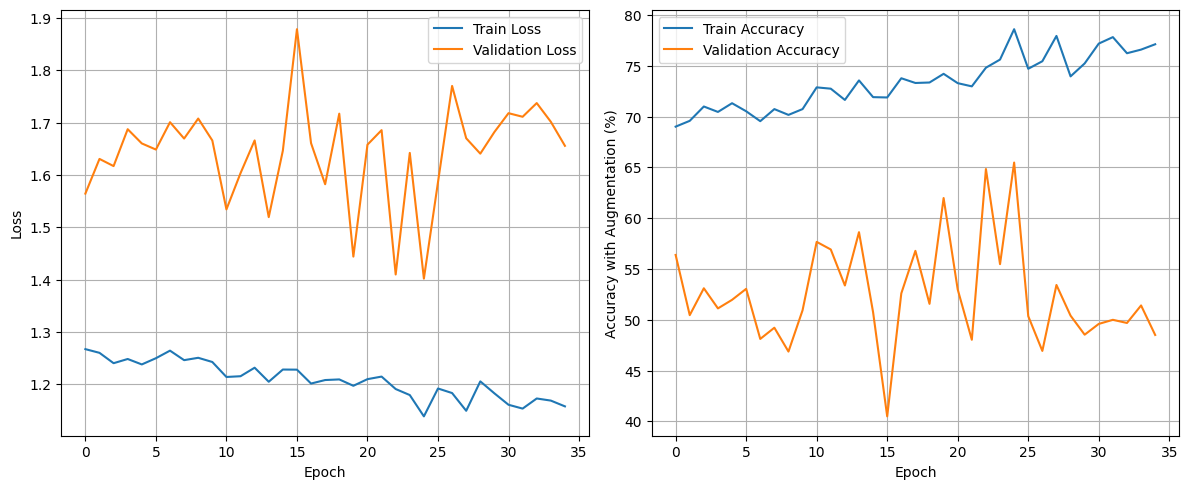

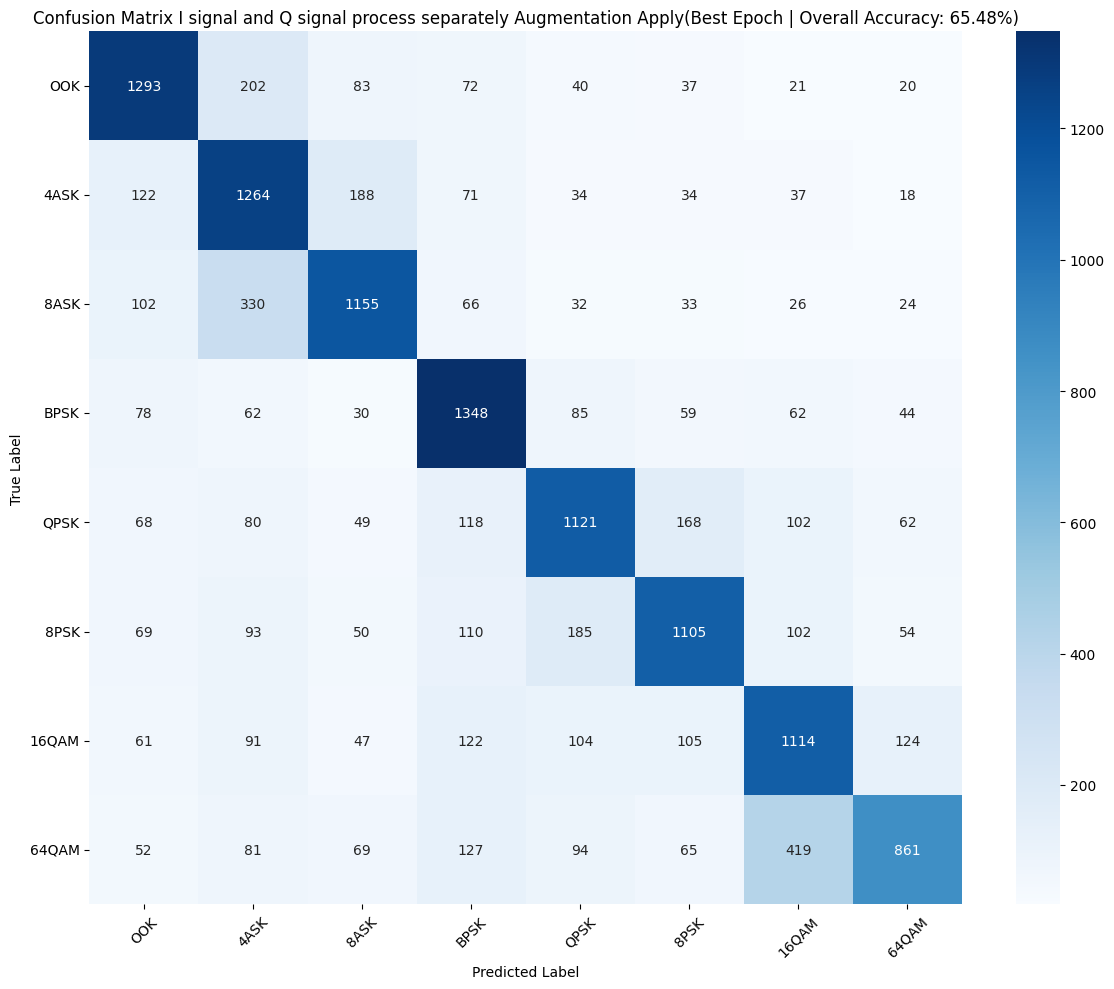

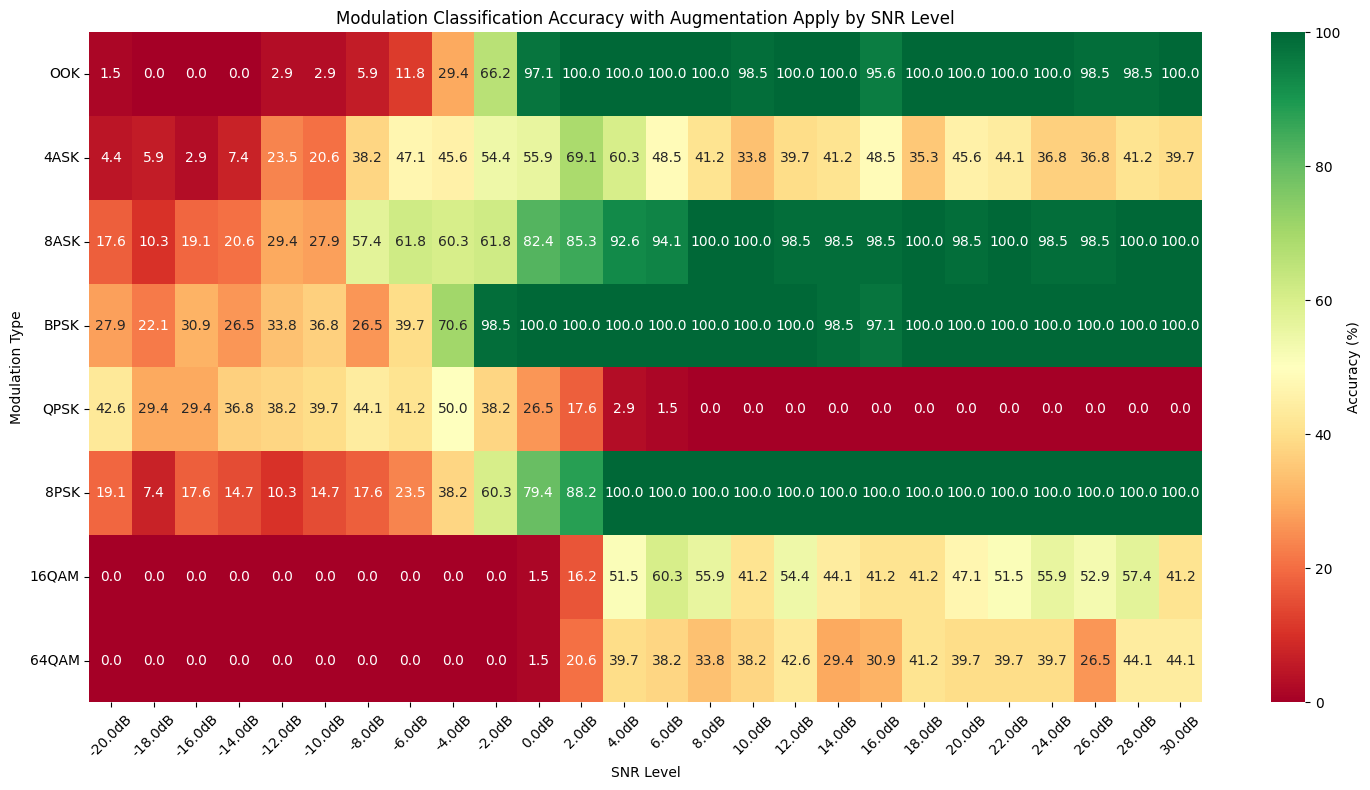

In [27]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    model_CNNIQ.parameters(), 
    lr=0.0015,  # Higher initial LR
    weight_decay=0.005,
    betas=(0.9, 0.999)
)

# Step scheduler
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[75, 125, 175], 
    gamma=0.5
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0,  # Use some workers for faster loading
    persistent_workers=False
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0,
    persistent_workers=False
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model_IQ.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        # === INLINE SIGNAL AUGMENTATION ===
        # Apply augmentation only during training
        if model_CNNIQ.training:
            batch_size = i_inputs.size(0)
            
            # 1. Add very small Gaussian noise (20% chance only)
            if torch.rand(1) > 0.8:
                noise_std = 0.005  # Much smaller noise
                i_inputs += torch.randn_like(i_inputs) * noise_std
                q_inputs += torch.randn_like(q_inputs) * noise_std
            
            # 2. Very small amplitude scaling (15% chance only)
            if torch.rand(1) > 0.85:
                scale = torch.empty(batch_size, 1, 1, 1).uniform_(0.95, 1.05).to(device)  # Much smaller range
                i_inputs *= scale
                q_inputs *= scale
            
            # 3. Phase rotation for I/Q signals (25% chance)
            if torch.rand(1) > 0.75:
                # Random phase shifts between -0.1 to 0.1 radians
                phase_shift = torch.empty(batch_size, 1, 1, 1).uniform_(-0.1, 0.1).to(device)
                
                # Apply rotation: [I', Q'] = [cos(θ) -sin(θ); sin(θ) cos(θ)] * [I; Q]
                cos_shift = torch.cos(phase_shift)
                sin_shift = torch.sin(phase_shift)
                
                i_rotated = i_inputs * cos_shift - q_inputs * sin_shift
                q_rotated = i_inputs * sin_shift + q_inputs * cos_shift
                
                i_inputs = i_rotated
                q_inputs = q_rotated
            
            # 4. Random amplitude/phase swapping (15% chance)
            if torch.rand(1) > 0.85:
                # Swap I and Q channels randomly for some samples
                swap_mask = torch.rand(batch_size, 1, 1, 1) > 0.5
                swap_mask = swap_mask.to(device)
                
                i_temp = i_inputs.clone()
                i_inputs = torch.where(swap_mask, q_inputs, i_inputs)
                q_inputs = torch.where(swap_mask, i_temp, q_inputs)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy with Augmentation (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal process separately Augmentation Apply(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('best_confusion_matrix.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('Modulation Classification Accuracy with Augmentation Apply by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    #plt.savefig('modulation_snr_accuracy_heatm.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNIQ, valid_loader, device, TARGET_MODULATIONS)

### 🎯 SNR-Specific Fine-Tuning Plan
    📊 Current Status: Major Breakthrough Achieved!
    - Base Model Performance: ✅ Excellent overall results
    - Enhanced Architecture: CNNIQModel with residual connections + attention
    - Key Achievement: 8PSK performance fixed (62.5% → 94-100%)
    - All Modulations: Working well with expected SNR behavior

### 🎯 Fine-Tuning Strategy
     - Approach: SNR-Specific Training
     - Create focused datasets for specific SNR ranges
     - Oversample weak combinations automatically
     - Lower learning rates to avoid destroying good performance
     - Targeted improvement without regression

In [6]:
class RadioMLIQFineTuningDataset(RadioMLIQDataset): 
    """
    On latest model, the training for Target modulation got overall good Accuracy, but it only appear on High Accuracy 
    SNR level.
    """
    def __init__(self,mode:str, snr_range = None, target_modulations= None, use_fft: bool = False, seed: int= 48,oversample_weak = True ): 
        super().__init__(mode, use_fft, seed)
        
        self.snr_range = snr_range
        self.target_modulations_filter = target_modulations
        self.oversample_weak = oversample_weak
        
        # Apply SNR filtering
        if snr_range is not None:
            min_snr, max_snr = snr_range
            snr_mask = (self.Z_data >= min_snr) & (self.Z_data <= max_snr)
            
            self.X_data = self.X_data[snr_mask]
            self.Y_data = self.Y_data[snr_mask]
            self.Z_data = self.Z_data[snr_mask]
            
            print(f"🎯 SNR filtering: {snr_range[0]}dB to {snr_range[1]}dB")
            print(f"📊 Samples after SNR filter: {len(self.X_data)}")
        
        # Apply modulation filtering if specified
        if target_modulations is not None:
            target_indices = [self.target_modulations.index(mod) for mod in target_modulations]
            mod_mask = np.isin(self.Y_data, target_indices)
            
            self.X_data = self.X_data[mod_mask]
            self.Y_data = self.Y_data[mod_mask]
            self.Z_data = self.Z_data[mod_mask]
            
            # Remap labels to be contiguous
            for new_idx, old_idx in enumerate(target_indices):
                self.Y_data[self.Y_data == old_idx] = new_idx + 1000  # Temporary unique values
            for new_idx in range(len(target_indices)):
                self.Y_data[self.Y_data == target_indices[new_idx] + 1000] = new_idx
            
            print(f"Modulation filtering: {target_modulations}")
            print(f"Samples after modulation filter: {len(self.X_data)}")
        
        # Oversample weak performing combinations
        if oversample_weak and snr_range is not None:
            self._oversample_weak_combinations()
        
        # Update statistics
        self.num_data = len(self.X_data)
        print(f"Fine-tuning dataset {mode}: {self.num_data} samples")
        
        # Print sample distribution
        self._print_distribution()

    def _oversample_weak_combinations(self): 
        # Define Weak Performance Criteria based on latest Heatmap" 
        weak_combination = [
            (2,-2), # BPSK below -2 dB 
            (4,2), # 8PSK below 2dB 
            (6,4), # 64QAM below 4 dB 
            (5,0), # !6QAM below 0 dB 
        ]
        oversample_indices = []
        original_length = len(self.X_data) 

        for mod_idx, snr_thresh in weak_combinations: 
            if mode_idx < len(self.target_modulations): 
                # find samples matching the weak combination 
                mask = (self.Y_data == mode_idx) & (self.Z_data <= snr_threads)
                weak_indices = np.where(mask)[0] 
                if len(weak_indices) > 0: 
                    # oversample by 2x for these combination 
                    oversample_indices.extend(weak_indices)
                    print(f"Over sampling {self.target_modulations[mod_idx]} at SNR <= {snr_thresh}dB: +{len(weak_indices)} samples")

                if oversample_indices: 
                    # add oversamples data
                    self.X_data = np.concatenate([self.X_data, self.X_data[oversample_indices]])
                    self.Y_data = np.concatenate([self.Y_data, self.Y_data[oversample_indices]])
                    self.Z_data = np.concatenate([self.Z_data, self.Z_data[oversample_indices]])

                    print(f"Oversampling complete : {original_length} ->  {len(self.X_data)} samples")

    def _print_distribution(self): 

        print("\n Sample Distribution : ") 

        #Distribution by modulation 
        unique_mods, mod_counts = np.unique(self.Y_data, return_counts = True)
        print("By modulation") 
        for mod_idx, count in zip(unique_mods, mod_counts): 
            if mod_idx < len(self.target_modulations): 
                mod_name = self.target_modulations[mod_idx] 
                percentage = 100 * count / len(self.Y_data) 
                print(f"{snr} dB samples ({percentage:.1f}%)") 
        # Distribution by SNR 
        unique_snrs, snr_counts = np.unique(self.Z_data, return_counts=True)
        print(f"\nBy SNR: {len(unique_snrs)} levels from {unique_snrs.min()}dB to {unique_snrs.max()}dB")
        if len(unique_snrs) <= 10:  # Only print details if not too many
            for snr, count in zip(unique_snrs, snr_counts):
                percentage = 100 * count / len(self.Z_data)
                print(f"  {snr}dB: {count} samples ({percentage:.1f}%)")

    @classmethod
    def create_snr_spesific_datasets(cls, base_mode = 'train', snr_range = None, **kwargs): 
        """
        Args:
            base_mode: Base dataset mode ('train', 'valid', 'test')
            snr_ranges: List of (min_snr, max_snr) tuples
            **kwargs: Additional arguments for dataset creation
        
        Returns:
            Dict of {range_name: dataset} for each SNR range
        """

        if snr_ranges in None: 
            snr_ranges = [
                (-20, -10, "very_low"),
                (-10, 0, "low"),
                (0, 10, "medium"), 
                (10, 30, "high"),
            ]
        datasets = {}
        for *snr_range, name in snr_ranges: 
            print(f"\n Dataset for {name} SNR range : {snr_range}") 
            dataset[name] = cls(
                mode = base_mode, 
                snr_range = tuple(snr_range), 
                **kwargs, 
            )

        return datasets 

In [18]:
def create_fine_tuning_setup(target_snr_range, problematic_modulations = None, batch_size = 1024, learning_rate_factor = 0.1): 
    """
        Args:
        target_snr_range: (min_snr, max_snr) tuple for fine-tuning focus
        problematic_modulations: List of modulations to focus on, or None for all
        batch_size: Batch size for fine-tuning (usually smaller than main training)
        learning_rate_factor: Multiply base learning rate by this factor
    
    Returns:
        Dictionary with train/valid loaders and suggested hyperparameters
    """
    print(f"Setting up fine-tuning for SNR range: {target_snr_range}")

    train_dataset = RadioMLIQFineTuningDataset(
        mode = 'train',
        snr_range=target_snr_range, 
        target_modulations = problematic_modulations, 
        oversample_weak = False 
    )

    valid_dataset = RadioMLIQFineTuningDataset(
        mode='valid', 
        snr_range=target_snr_range,
        target_modulations=problematic_modulations,
        oversample_weak=False  # No oversampling for validation
    )
    train_loader = DataLoader(
        train_dataset, 
        batch_size = batch_size, 
        shuffle = True, 
        pin_memory = True, 
        num_workers = 0, 
        persistent_workers = False
    )

    valid_loader = DataLoader(
        valid_dataset, 
        batch_size = batch_size, 
        shuffle = False,
        pin_memory = True, 
        num_workers = 0, 
        persistent_workers = False
    )

    base_lr = 0.0015 
    fine_tune_config = {
        'learning_rate': base_lr * learning_rate_factor,
        'weight_decay': 0.001, 
        'epochs' : 50, 
        'patience': 100, 
        'scheduler': 'cosine', 
        'label_smoothing': 0.05
    }

    print(f"fine-tuning configuration :")
    for key, value in fine_tune_config.items():
        print(f"{key}: {value}") 
        
    return {
        'train_loader': train_loader,
        'valid_loader': valid_loader,
        'train_dataset': train_dataset,
        'valid_dataset': valid_dataset,
        'config': fine_tune_config
    }

In [19]:
def get_fine_tuning_strategies():
    """Return suggested fine-tuning strategies based on common weak points"""
    
    strategies = {
        'low_snr_focus': {
            'description': 'Focus on challenging low SNR conditions',
            'snr_range': (-10, 0),
            'modulations': None,  # All modulations
            'learning_rate_factor': 0.1,
            'epochs': 75
        },
        
        'complex_modulations': {
            'description': 'Focus on complex modulations across all SNRs',
            'snr_range': None,  # All SNRs
            'modulations': ['8PSK', '16QAM', '64QAM'],
            'learning_rate_factor': 0.05,
            'epochs': 50
        },
        
        'medium_snr_refinement': {
            'description': 'Refine performance in medium SNR range',
            'snr_range': (-5, 5),
            'modulations': None,
            'learning_rate_factor': 0.2,
            'epochs': 40
        },
        
        'problematic_combinations': {
            'description': 'Target specific weak modulation-SNR combinations',
            'snr_range': (-8, 2),
            'modulations': ['8PSK', '64QAM', '8ASK'],
            'learning_rate_factor': 0.1,
            'epochs': 60
        }
    }
    
    return strategies

In [20]:
setup = create_fine_tuning_setup(
        target_snr_range=(-10, 0),
        problematic_modulations=['8PSK', '64QAM'],
        batch_size=512
    )


Setting up fine-tuning for SNR range: (-10, 0)
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🎯 SNR filtering: -10dB to 0dB
📊 Samples after SNR filter: 11424
Modulation filtering: ['8PSK', '64QAM']
Samples after modulation filter: 2856
Fine-tuning dataset train: 2856 samples

 Sample Distribution : 
By modulation

By SNR: 6 levels from -10dB to 0dB
  -10dB: 476 samples (16.7%)
  -8dB: 476 samples (16.7%)
  -6dB: 476 samples (16.7%)
  -4dB: 476 samples (16.7%)
  -2dB: 476 samples (16.7%)
  0dB: 476 samples (16.7%)
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset valid: 14144 samples, 8 classes, 26 SNR levels
🎯 SNR filtering: -10dB to 0dB
📊 Samples after SNR filter: 3264
Modulation filtering: ['8PSK', '64QAM']
Samples after modulation filter: 816
Fine-tuning 

In [21]:
import os
if os.path.exists('best_cnn_model_IQ.pth'):
    model_CNNIQ.load_state_dict(torch.load('best_cnn_model_IQ.pth'))
    model_CNNIQ.eval()
    print(model_CNNIQ.eval())
    print(f"✅ Loaded model from: {'best_cnn_model_IQ.pth'}")
else:
    print(f"❌ Model file not found: {'best_cnn_model_IQ.pth'}")
    print("Available files:", os.listdir('.'))

CNNIQModel(
  (i_branch): CNNIQBranch(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (leaky_relu): LeakyReLU(negative_slope=0.1, inplace=True)
    (dropout): Dropout2d(p=0.15000000000000002, inplace=False)
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
 

In [22]:
fine_tune_setup = create_fine_tuning_setup(
        target_snr_range=(-10, 0),
        problematic_modulations=['8PSK', '64QAM'],
        batch_size=512,
        learning_rate_factor = 0.1
    )
ft_train_loader = fine_tune_setup['train_loader']
ft_valid_loader = fine_tune_setup['valid_loader'] 
ft_config = fine_tune_setup['config']

Setting up fine-tuning for SNR range: (-10, 0)
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 49504 samples, 8 classes, 26 SNR levels
🎯 SNR filtering: -10dB to 0dB
📊 Samples after SNR filter: 11424
Modulation filtering: ['8PSK', '64QAM']
Samples after modulation filter: 2856
Fine-tuning dataset train: 2856 samples

 Sample Distribution : 
By modulation

By SNR: 6 levels from -10dB to 0dB
  -10dB: 476 samples (16.7%)
  -8dB: 476 samples (16.7%)
  -6dB: 476 samples (16.7%)
  -4dB: 476 samples (16.7%)
  -2dB: 476 samples (16.7%)
  0dB: 476 samples (16.7%)
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset valid: 14144 samples, 8 classes, 26 SNR levels
🎯 SNR filtering: -10dB to 0dB
📊 Samples after SNR filter: 3264
Modulation filtering: ['8PSK', '64QAM']
Samples after modulation filter: 816
Fine-tuning 

In [23]:
ft_config = fine_tune_setup['config']
ft_config

{'learning_rate': 0.00015000000000000001,
 'weight_decay': 0.001,
 'epochs': 50,
 'patience': 100,
 'scheduler': 'cosine',
 'label_smoothing': 0.05}

### Congigure Fine-Tuning Optimizer

In [26]:
# Set up conservative fine-tuning hyperparameters
print("\n⚙️ Configuring fine-tuning hyperparameters...")

ft_criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Less smoothing

ft_optimizer = optim.AdamW(
    model_CNNIQ.parameters(), 
    lr=ft_config['learning_rate'],  # 0.00015 (10x lower)
    weight_decay=ft_config['weight_decay'],  # 0.001
    betas=(0.9, 0.999)
)

ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    ft_optimizer, 
    T_max=ft_config['epochs'],  # 50 epochs
    eta_min=1e-7
)

print(f"✅ Fine-tuning LR: {ft_config['learning_rate']} (10x lower than base)")
print(f"✅ Epochs: {ft_config['epochs']}")
print(f"✅ Patience: {ft_config['patience']}")


⚙️ Configuring fine-tuning hyperparameters...
✅ Fine-tuning LR: 0.00015000000000000001 (10x lower than base)
✅ Epochs: 50
✅ Patience: 100


### Fine tuning Training Loop 

In [27]:
# Fixed fine-tuning training loop with proper error handling
ft_train_losses = []
ft_valid_losses = []
ft_train_accuracies = []
ft_valid_accuracies = []
ft_best_accuracy = 0.0
ft_patience_counter = 0
ft_patience = ft_config['patience']
FT_MODEL_PATH = 'finetuned_low_medium_snr.pth'

print("\n🚀 Starting Phase 1 Fine-tuning...")
print("⚠️  Using conservative learning rate to preserve existing performance")

try:
    for epoch in tqdm(range(ft_config['epochs']), desc="Fine-tuning Epochs", ncols=80):  # Fixed: 'epochs' not 'epoch'
        # ============================================================================
        # FINE-TUNING TRAINING PHASE
        # ============================================================================
        model_CNNIQ.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i_inputs, q_inputs, labels, _ in tqdm(ft_train_loader, desc="FT Training", leave=False, ncols=60):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            # Add safety check for labels
            if labels.max() >= NUM_CLASSES or labels.min() < 0:
                print(f"❌ Invalid labels detected: {labels.min().item()} to {labels.max().item()}")
                print(f"Expected range: 0 to {NUM_CLASSES-1}")
                break

            ft_optimizer.zero_grad()
            
            with autocast():
                outputs = model_CNNIQ(i_inputs, q_inputs)
                loss = ft_criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(ft_optimizer)
            scaler.update()

            running_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(fine_tune_setup['train_dataset'])
        epoch_train_accuracy = 100. * correct_train / total_train
        ft_train_losses.append(epoch_train_loss)
        ft_train_accuracies.append(epoch_train_accuracy)

        # ============================================================================
        # VALIDATION ON TARGET SNR RANGE
        # ============================================================================
        model_CNNIQ.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for i_inputs, q_inputs, labels, _ in tqdm(ft_valid_loader, desc="FT Validation", leave=False, ncols=60):
                i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
                labels = labels.to(device)

                # Add safety check for validation labels too
                if labels.max() >= NUM_CLASSES or labels.min() < 0:
                    print(f"❌ Invalid validation labels: {labels.min().item()} to {labels.max().item()}")
                    continue

                outputs = model_CNNIQ(i_inputs, q_inputs)
                loss = ft_criterion(outputs, labels)

                valid_loss += loss.item() * i_inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        epoch_valid_loss = valid_loss / len(fine_tune_setup['valid_dataset'])
        epoch_valid_accuracy = 100. * correct_valid / total_valid
        ft_valid_losses.append(epoch_valid_loss)
        ft_valid_accuracies.append(epoch_valid_accuracy)
        
        ft_scheduler.step()
        
        # Save best fine-tuned model (uncommented)
        if epoch_valid_accuracy > ft_best_accuracy:
            ft_best_accuracy = epoch_valid_accuracy
            ft_patience_counter = 0
            torch.save(model_CNNIQ.state_dict(), FT_MODEL_PATH)
            print(f"💾 New best fine-tuning accuracy: {ft_best_accuracy:.2f}% - Model saved!")
        else:
            ft_patience_counter += 1
            if ft_patience_counter >= ft_patience:
                print(f"⏹️  Fine-tuning early stopping at epoch {epoch+1}")
                break

        print(f"FT Epoch {epoch+1}/{ft_config['epochs']}: "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Train Acc: {epoch_train_accuracy:.2f}% | "
              f"Valid Loss: {epoch_valid_loss:.4f} | "
              f"Valid Acc: {epoch_valid_accuracy:.2f}%")

except Exception as e:
    print(f"❌ Error during fine-tuning: {e}")
    print("🔍 Debugging info:")
    print(f"  NUM_CLASSES: {NUM_CLASSES}")
    print(f"  Model output shape: {outputs.shape if 'outputs' in locals() else 'Unknown'}")
    print(f"  Labels shape: {labels.shape if 'labels' in locals() else 'Unknown'}")
    print(f"  Labels range: {labels.min().item() if 'labels' in locals() else 'Unknown'} to {labels.max().item() if 'labels' in locals() else 'Unknown'}")

print(f"\n✅ Phase 1 Fine-tuning complete!")
print(f"🎯 Best fine-tuning accuracy on target SNR range: {ft_best_accuracy:.2f}%")


🚀 Starting Phase 1 Fine-tuning...
⚠️  Using conservative learning rate to preserve existing performance


Fine-tuning Epochs:   0%|                                | 0/50 [00:00<?, ?it/s]

❌ Invalid labels detected: 1000 to 1001
Expected range: 0 to 7
❌ Error during fine-tuning: float division by zero
🔍 Debugging info:
  NUM_CLASSES: 8
  Model output shape: Unknown
  Labels shape: torch.Size([512])
  Labels range: 1000 to 1001

✅ Phase 1 Fine-tuning complete!
🎯 Best fine-tuning accuracy on target SNR range: 0.00%
